# Notebook ML : Pr√©diction de la Date de Fin de Menace, Clustering Th√©matique et Alertes Email

Ce notebook int√®gre¬†:
- Un mod√®le supervis√© pour l‚Äôimputation des valeurs manquantes, en particulier la date de fin de menace (`finalerte`).
- Un mod√®le non supervis√© pour le regroupement th√©matique des vuln√©rabilit√©s.
- Un syst√®me d‚Äôalerte email pour notifier les vuln√©rabilit√©s critiques d√©tect√©es.

## 1. Importation des Librairies

On importe les librairies n√©cessaires pour la manipulation des donn√©es, le machine learning, la visualisation et l‚Äôenvoi d‚Äôemails.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import datetime

import smtplib
from email.mime.text import MIMEText

import warnings
warnings.filterwarnings('ignore')

## 2. Chargement et Pr√©paration des Donn√©es

On charge le fichier CSV enrichi, on convertit les dates, on affiche les colonnes, on encode les variables cat√©gorielles, et on identifie les valeurs manquantes (notamment la date de fin de menace).

In [29]:
# Charger les donn√©es enrichies - CORRECTION du nom de fichier
df = pd.read_csv('../data/cve_cleaned_for_df.csv')

# Afficher les colonnes et un aper√ßu
print("Colonnes du CSV :", list(df.columns))
print(df.head(2))

# Conversion des dates - CORRECTION des noms de colonnes
df['Publi√©e le'] = pd.to_datetime(df['Publi√©e le'], errors='coerce')
df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"], errors='coerce')

# Encodage des variables cat√©gorielles principales - CORRECTION des noms
cat_cols = ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str)

# Encodage label pour les variables cat√©gorielles (pour ML)
label_encoders = {}
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col+'_enc'] = le.fit_transform(df[col])
        label_encoders[col] = le

# Conversion des scores en num√©rique - CORRECTION des noms
df['Score CVSS'] = df['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')

df['Score EPSS'] = df['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')

# Affichage des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Focus sur la colonne cible pour la pr√©diction supervis√©e - CORRECTION
print("\nExemples de valeurs de \"Date de fin d'alerte\" :")
print(df["Date de fin d'alerte"].head(10))

Colonnes du CSV : ['Identifiant ANSSI', 'Titre', 'Type (Avis ou Alerte)', 'Publi√©e le', "Date de fin d'alerte", 'ID CVE', 'Score CVSS', 'Base Severity', 'Score EPSS', 'ID CWE', 'Description CWE', 'Lien', 'Description', 'Vendeur', 'Produit', 'Version Affect√©s', 'Diff√©rence en jours']
     Identifiant ANSSI                                              Titre Type (Avis ou Alerte)                 Publi√©e le       Date de fin d'alerte          ID CVE Score CVSS Base Severity  Score EPSS          ID CWE Description CWE                                               Lien                                        Description    Vendeur         Produit                                   Version Affect√©s Diff√©rence en jours
0  CERTFR-2022-ALE-007  Multiples vuln√©rabilit√©s dans Microsoft Window...                alerte  2022-09-16 00:00:00+00:00  2023-03-14 00:00:00+00:00  CVE-2022-34718        9.8      CRITICAL     0.84306  Non disponible  Non disponible  https://www.cert.ssi.gouv.fr/alerte/C

# 3. Vizualisation des donn√©es

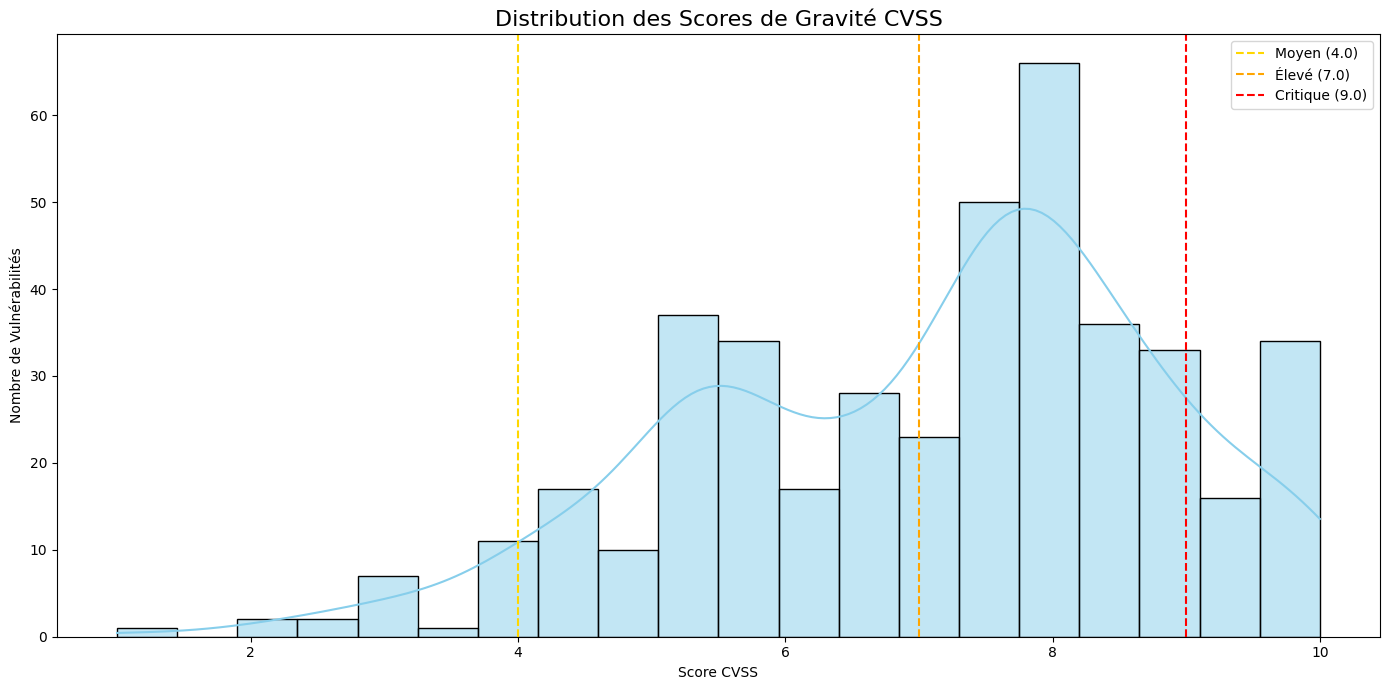

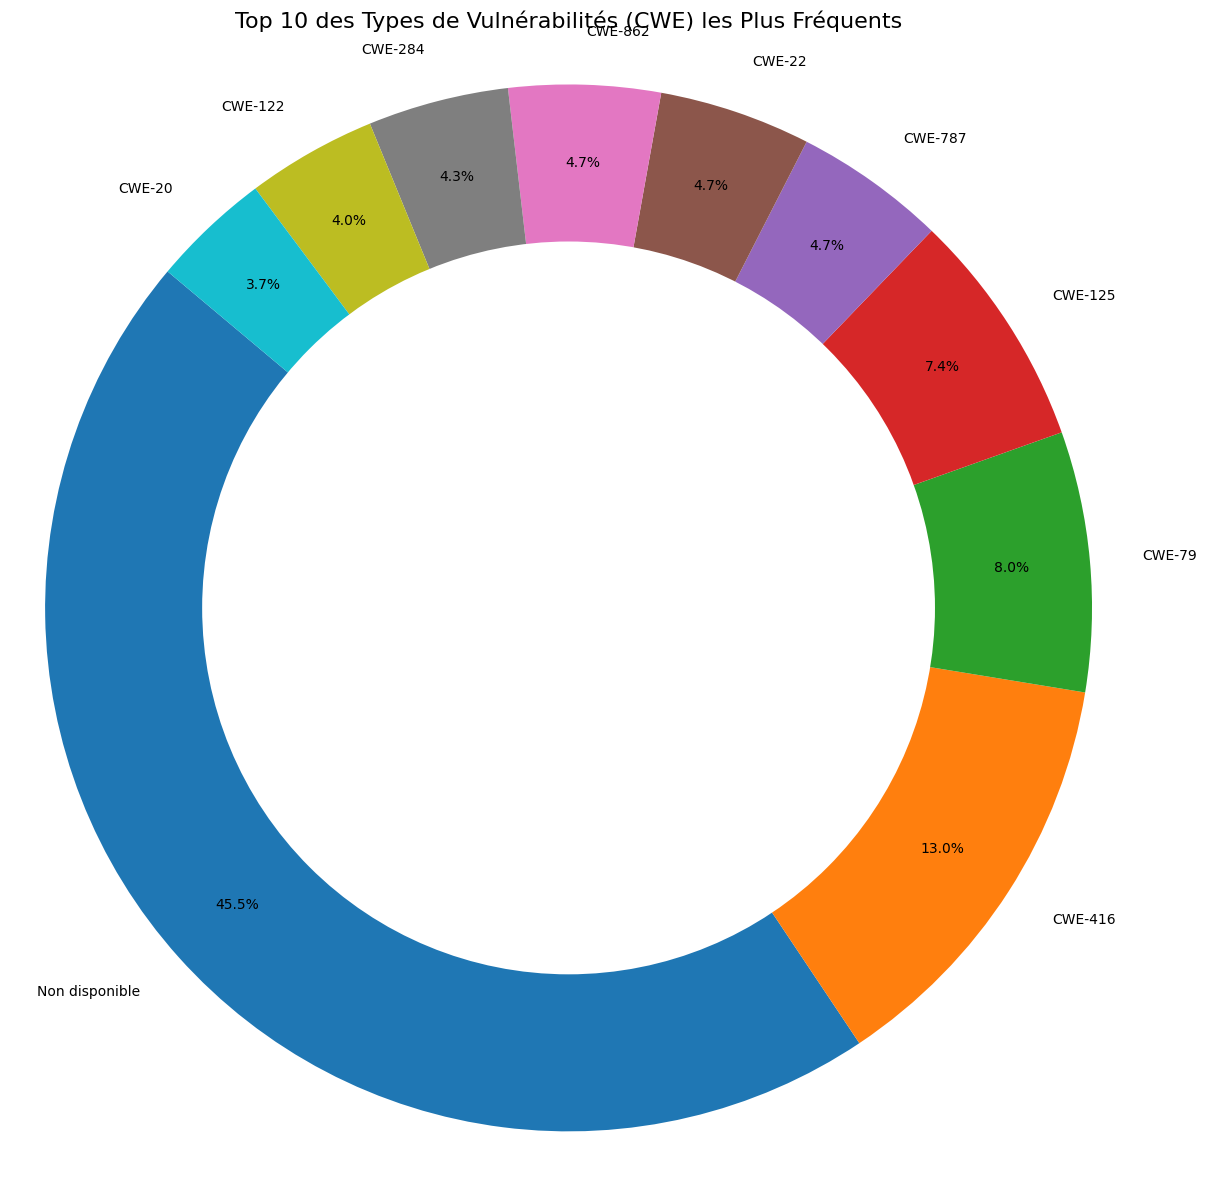

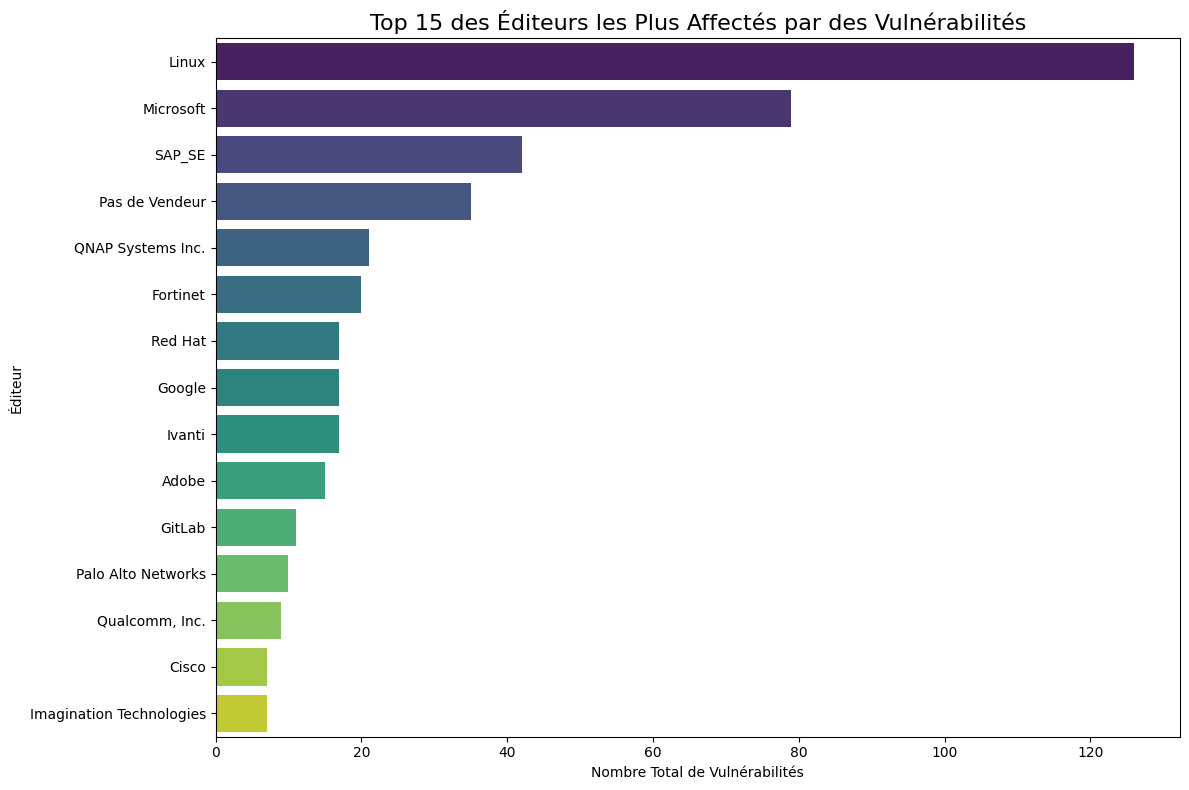

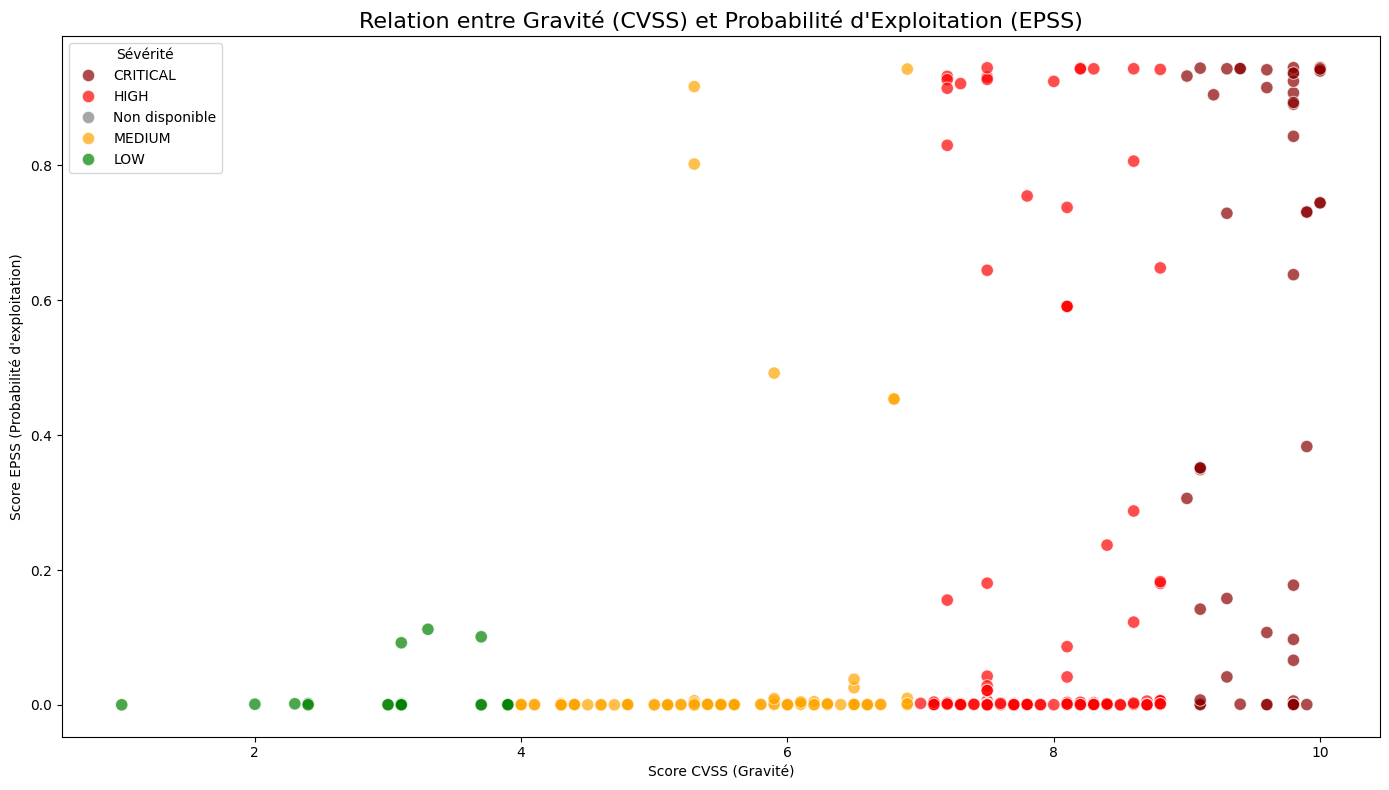

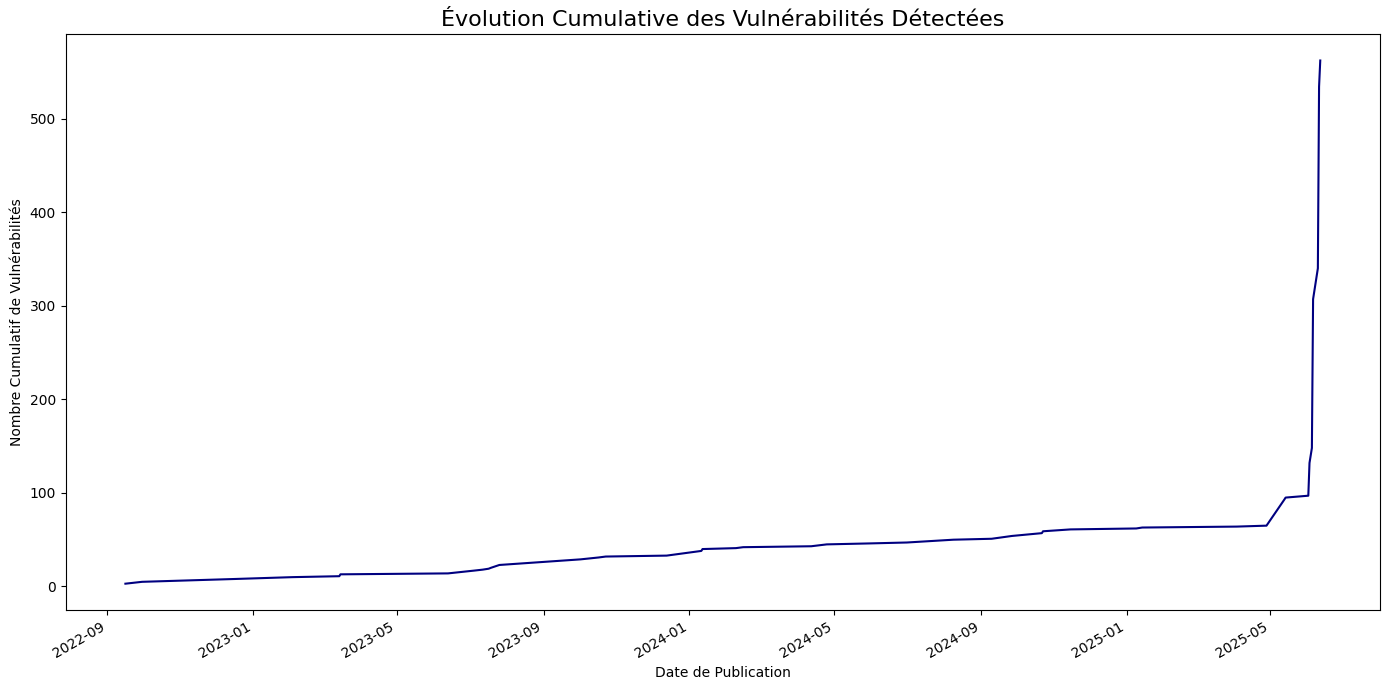

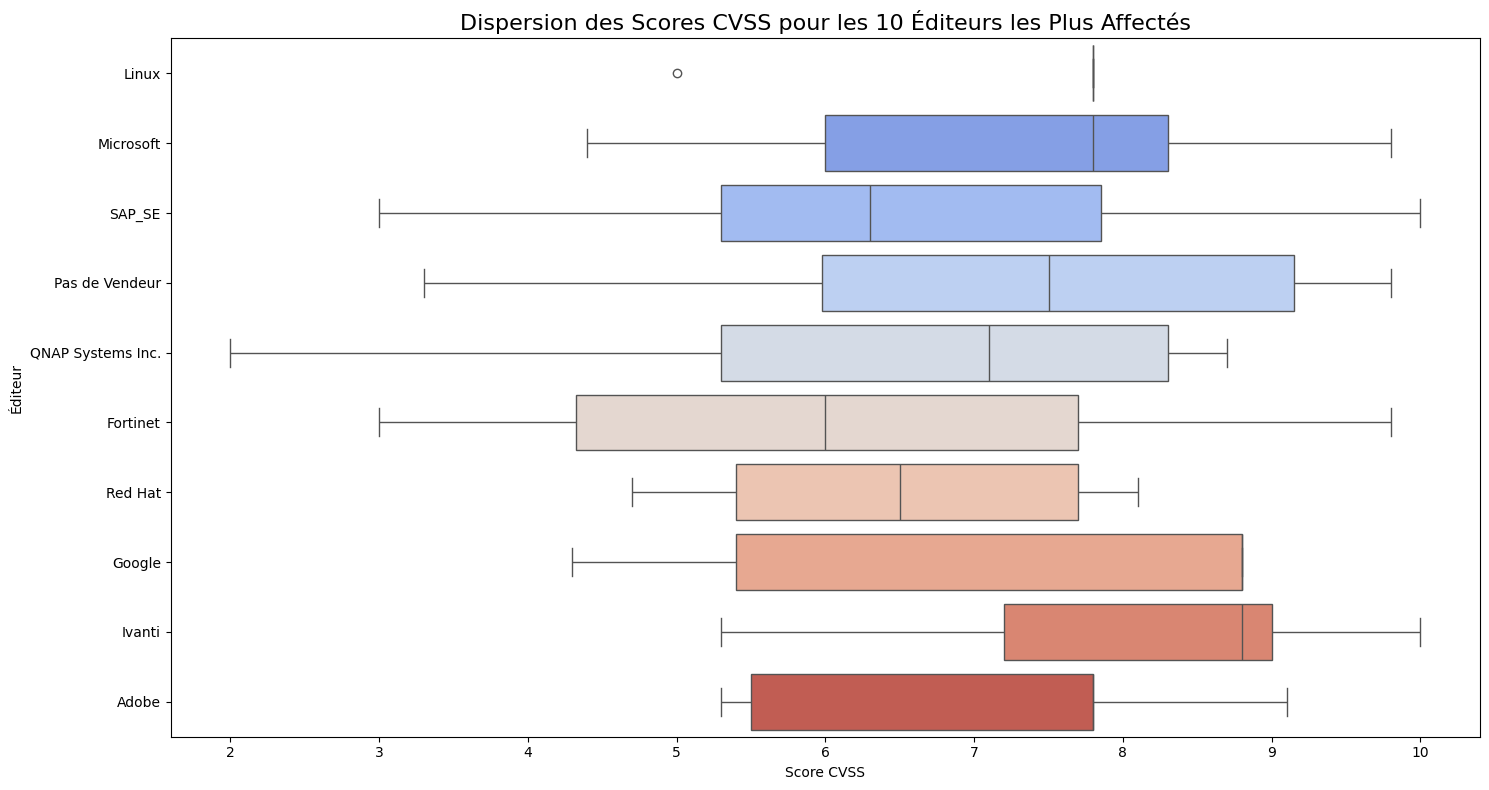

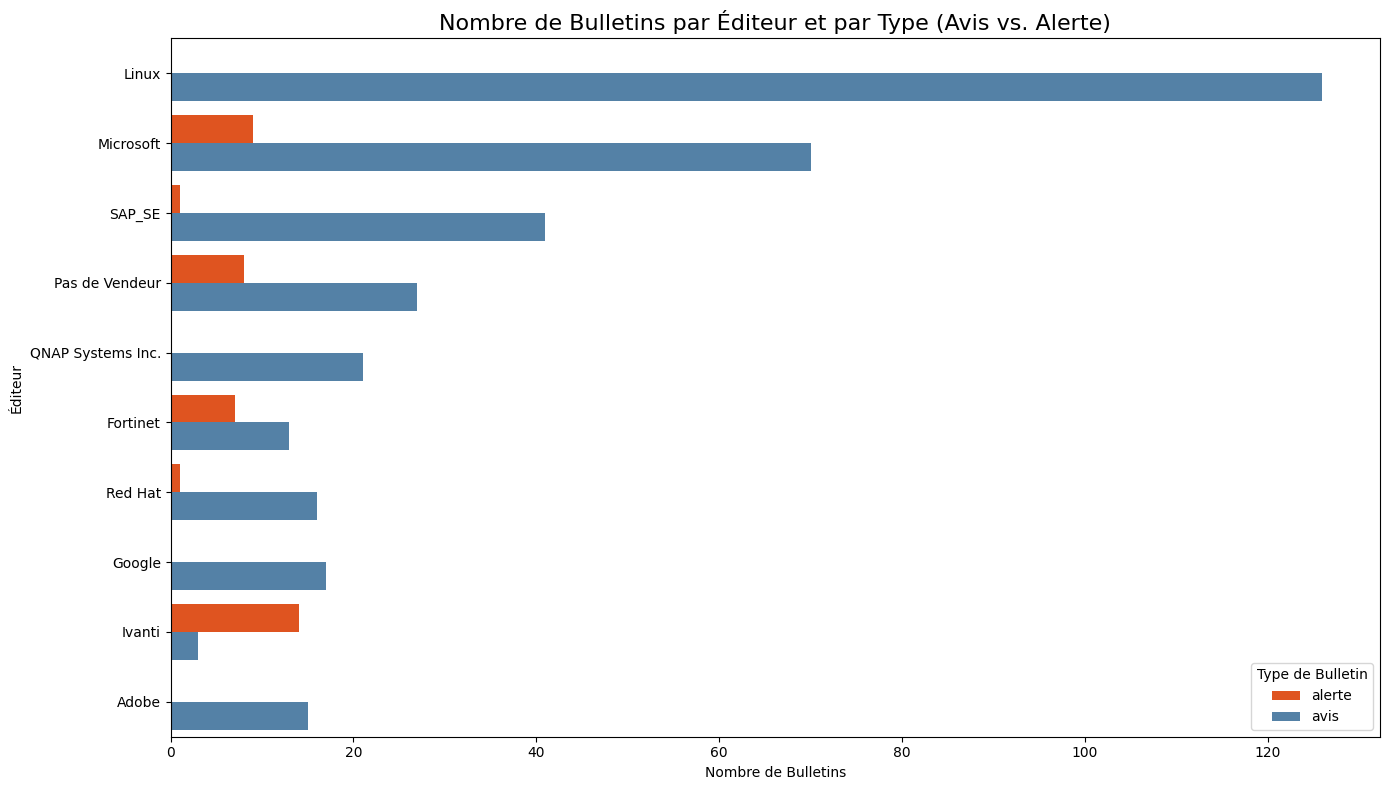

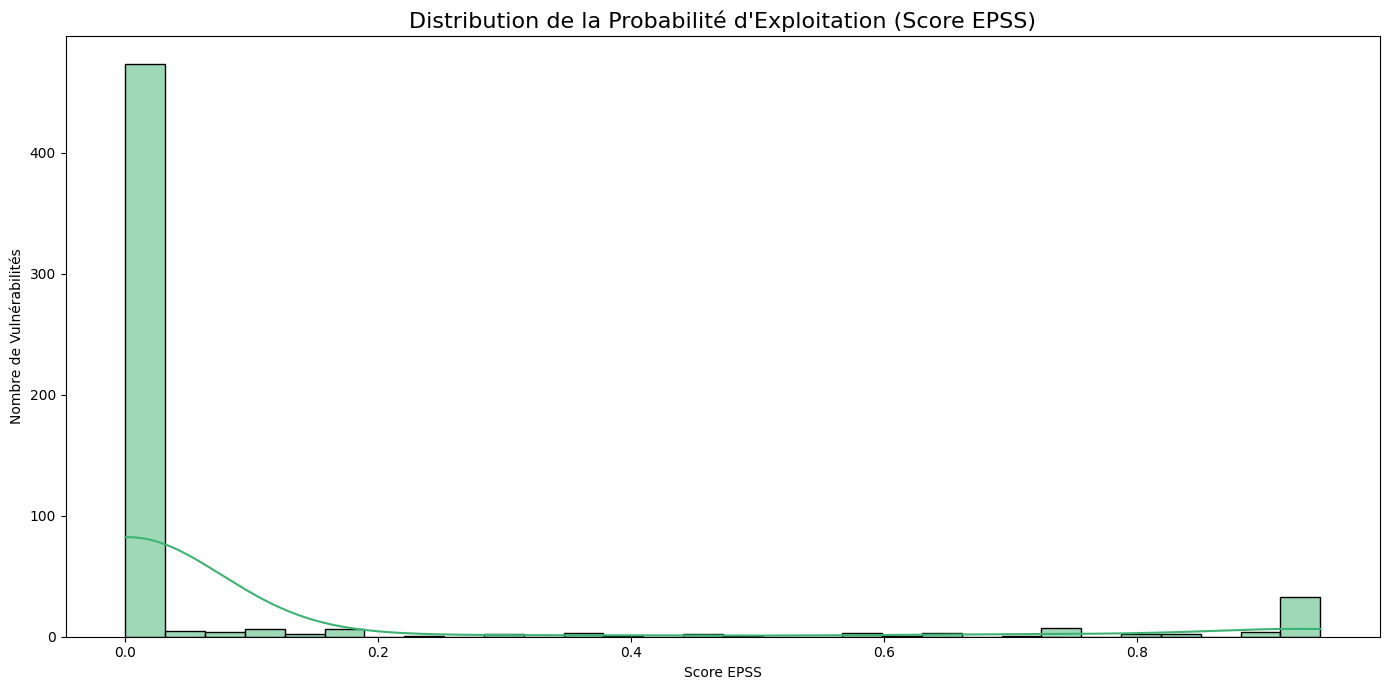

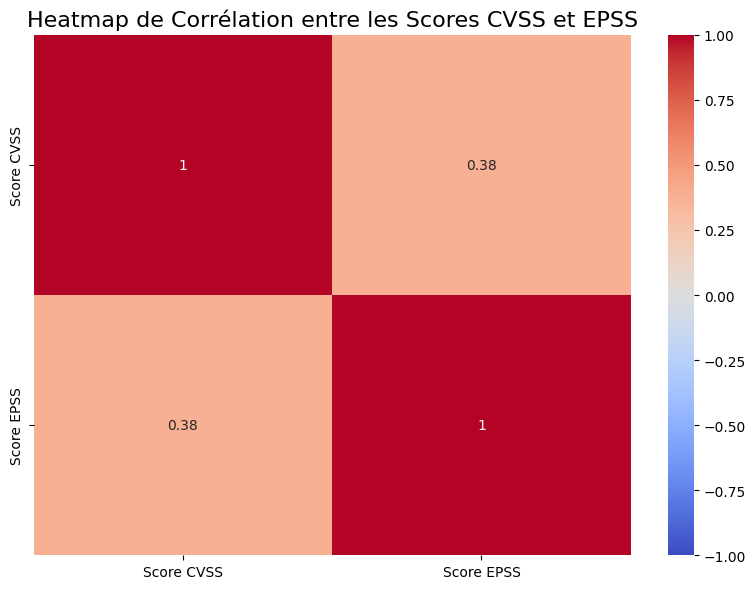

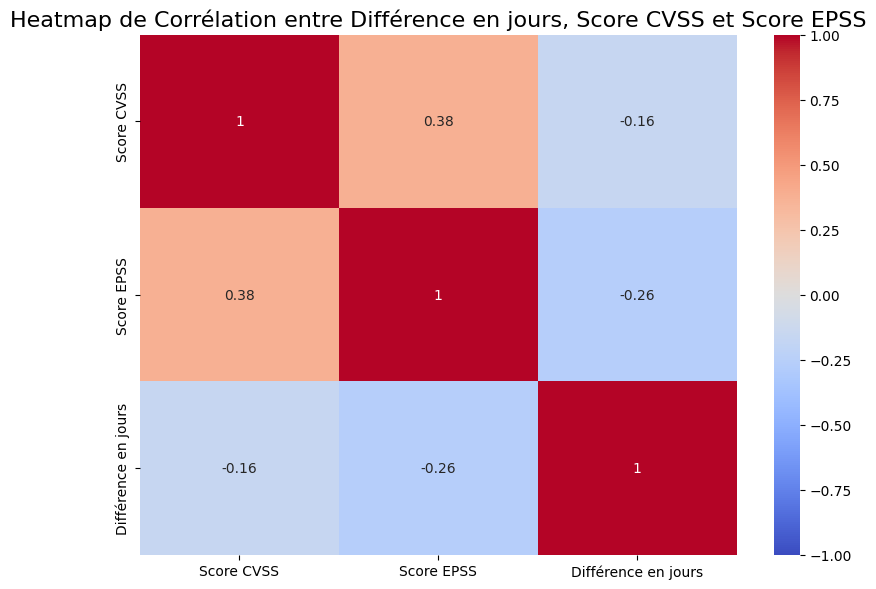

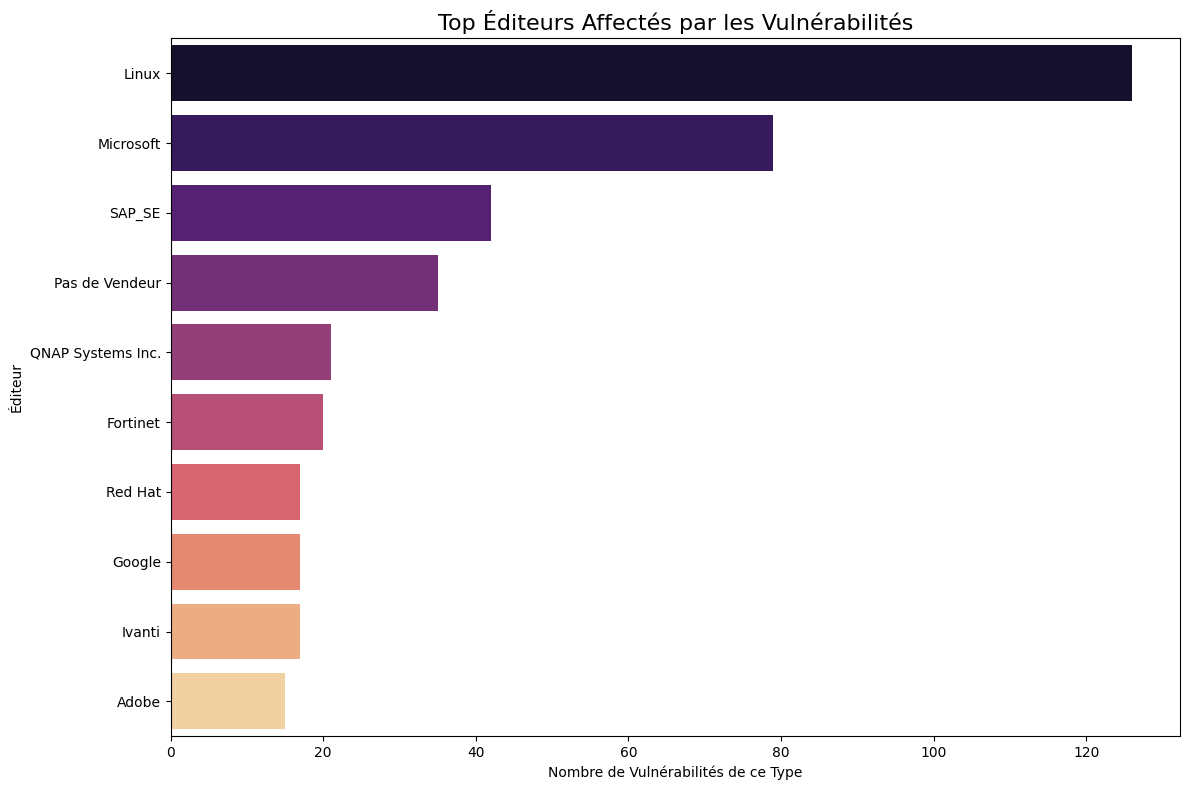

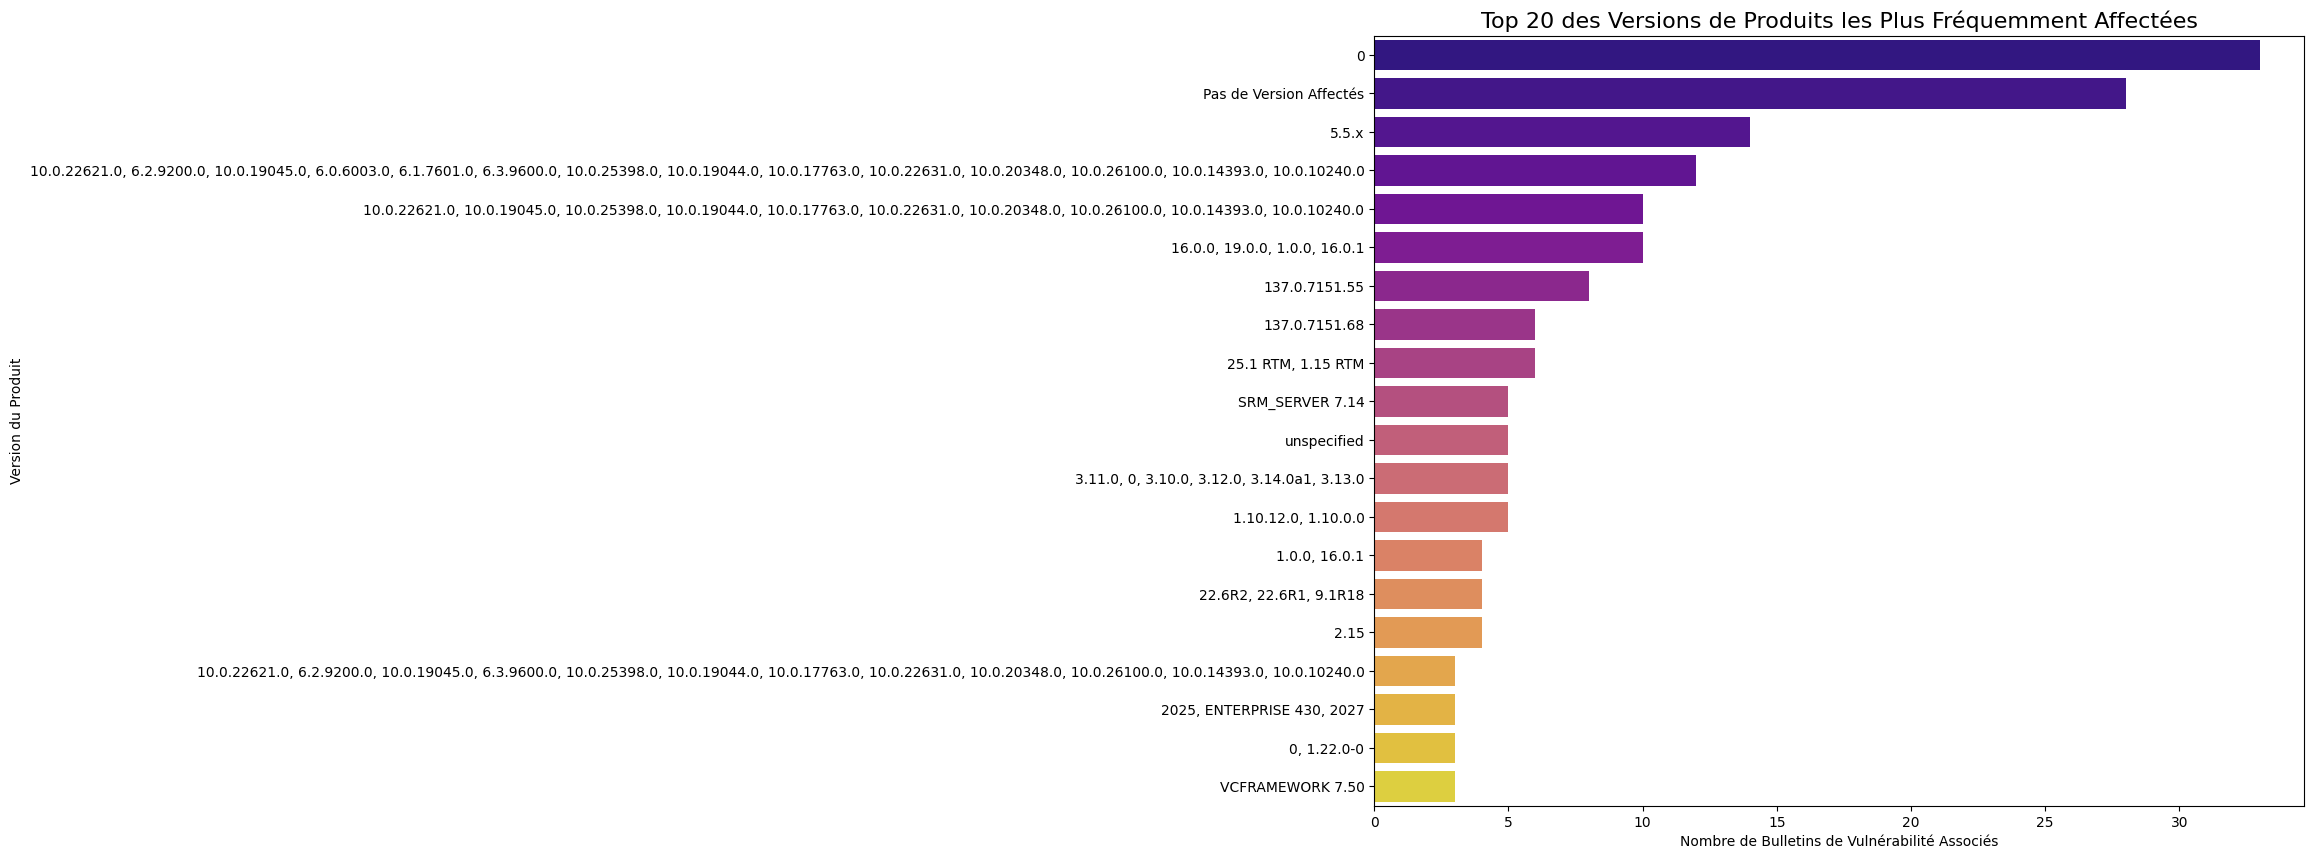

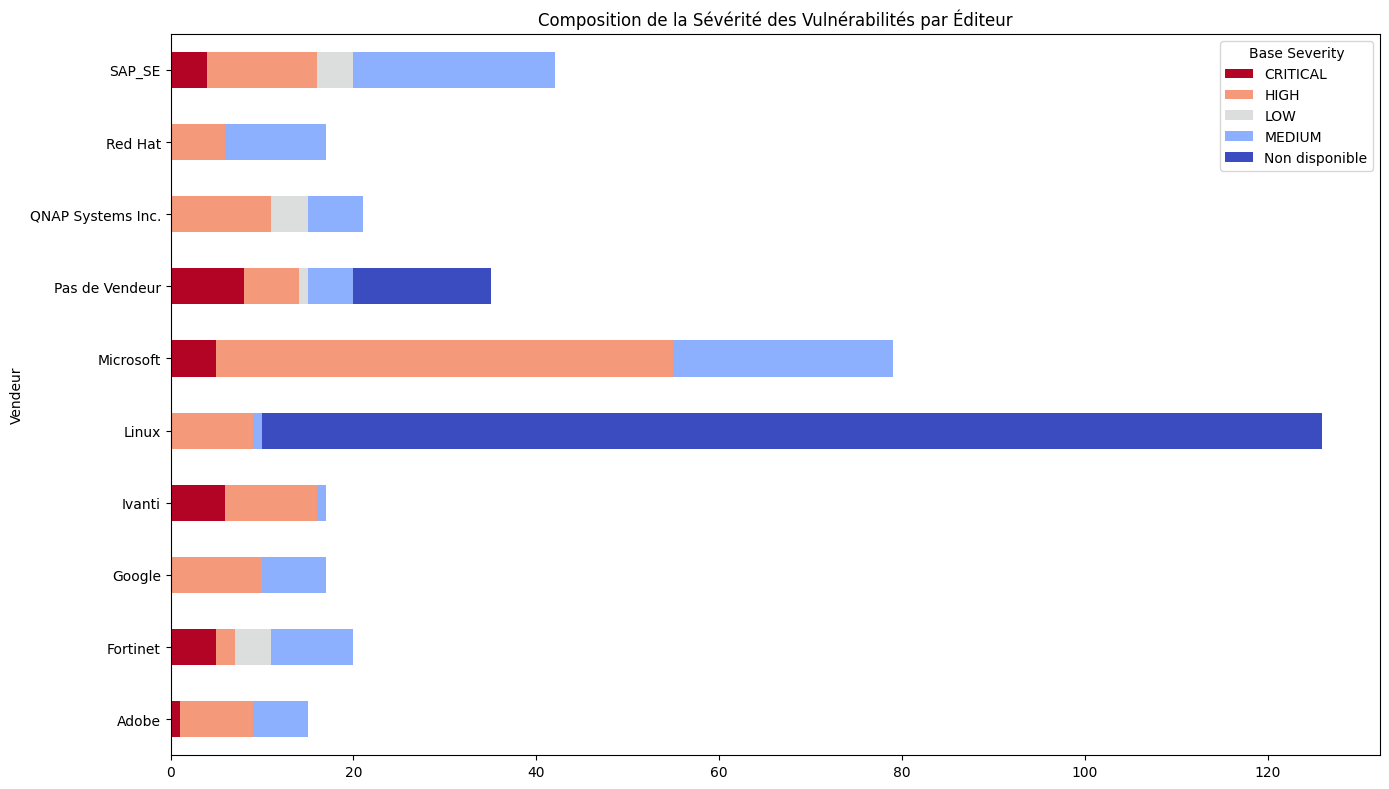

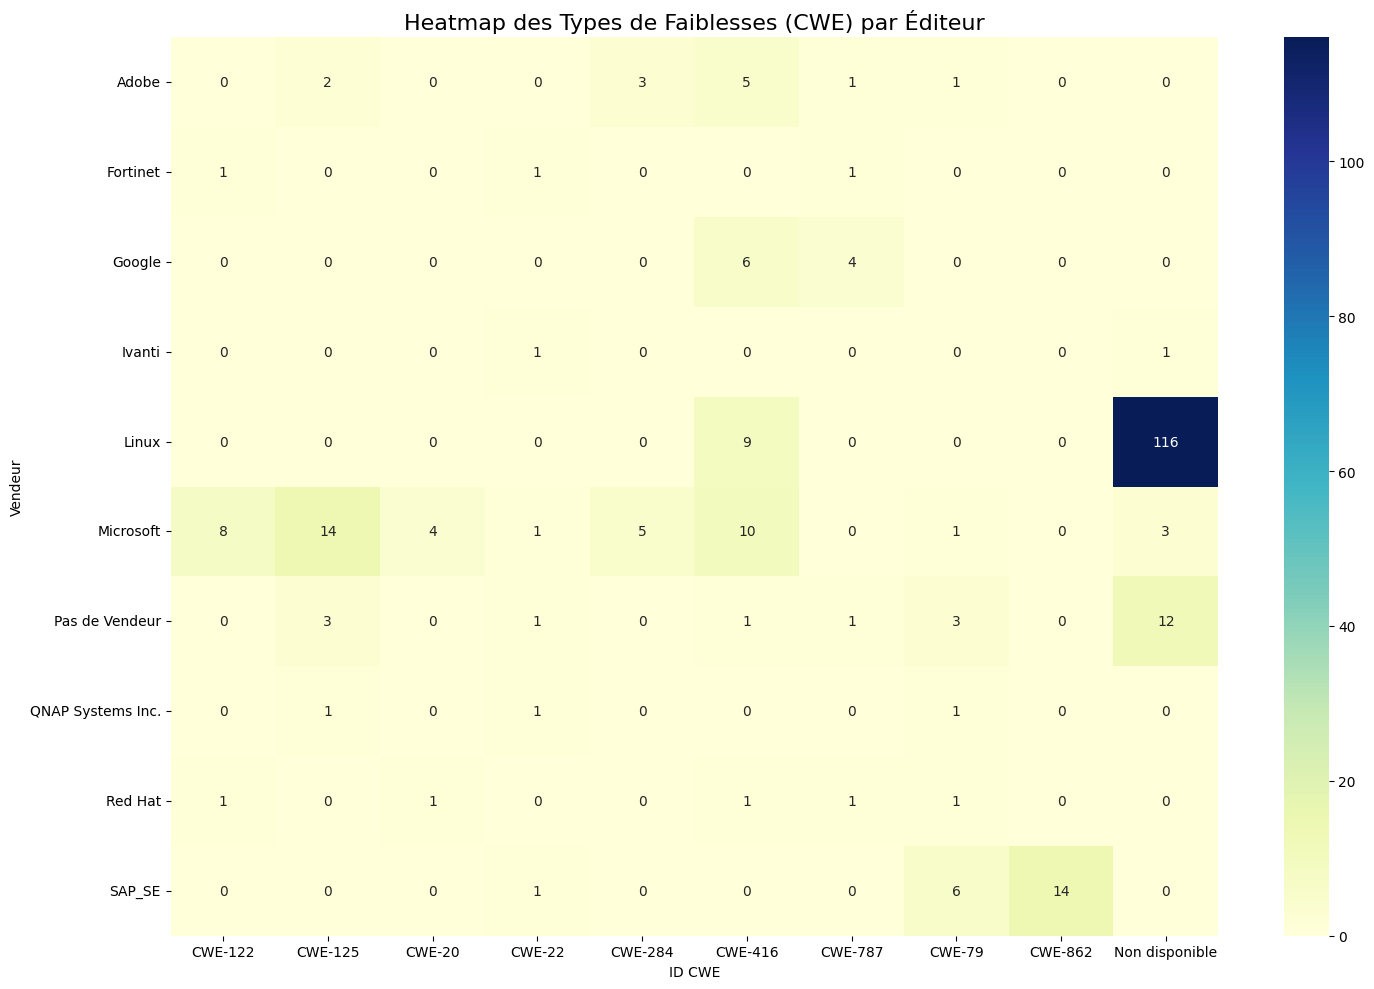

In [30]:
# Cr√©er le dossier si n√©cessaire
os.makedirs("diagrams", exist_ok=True)

# Configuration de l'affichage
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Lecture et renommage des colonnes
df = pd.read_csv("../data/cve_cleaned_for_df.csv")
df = df[[
    "Identifiant ANSSI",
    "Titre",
    "Type (Avis ou Alerte)",
    "Publi√©e le",
    "Date de fin d'alerte",
    "ID CVE",
    "Score CVSS",
    "Base Severity",
    "Score EPSS",
    "ID CWE",
    "Description CWE",
    "Lien",
    "Description",
    "Vendeur",
    "Produit",
    "Version Affect√©s",
    "Diff√©rence en jours"
]]  

# Fonctions de nettoyage pour les colonnes sous forme de string
def clean_vendor(vendor_str):
    if isinstance(vendor_str, str):
        vendors = [v.strip() for v in vendor_str.split(",")]
        unique_vendors = set(vendors)
        return ", ".join(unique_vendors)
    return vendor_str

def clean_versions(versions_str):
    if isinstance(versions_str, str):
        versions = [v.strip() for v in versions_str.split(",")]
        unique_versions = set(versions)
        return ", ".join(unique_versions)
    return versions_str

df["Vendeur"] = df["Vendeur"].apply(clean_vendor)
df["Version Affect√©s"] = df["Version Affect√©s"].apply(clean_versions)

# Conversion des scores en num√©rique si n√©cessaire
df["Score CVSS"] = pd.to_numeric(df["Score CVSS"], errors="coerce")
df["Score EPSS"] = pd.to_numeric(df["Score EPSS"], errors="coerce")

# Conversion de la date de publication en datetime
df["Publi√©e le"] = pd.to_datetime(df["Publi√©e le"], errors="coerce")

# ---------------------------
# 1. Histogramme des Scores CVSS
plt.figure(figsize=(14, 7))
sns.histplot(df['Score CVSS'], bins=20, kde=True, color='skyblue')
plt.axvline(x=4.0, color='gold', linestyle='--', label='Moyen (4.0)')
plt.axvline(x=7.0, color='orange', linestyle='--', label='√âlev√© (7.0)')
plt.axvline(x=9.0, color='red', linestyle='--', label='Critique (9.0)')
plt.title('Distribution des Scores de Gravit√© CVSS', fontsize=16)
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de Vuln√©rabilit√©s')
plt.legend()
plt.tight_layout()
plt.savefig("diagrams/histogram_cvss.png", dpi=300)
plt.show()

# ---------------------------
# 2. Diagramme circulaire (Donut) pour le Top 10 des CWE
top_cwe = df['ID CWE'].value_counts().nlargest(10)
plt.figure(figsize=(12, 12))
plt.pie(top_cwe, labels=top_cwe.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Top 10 des Types de Vuln√©rabilit√©s (CWE) les Plus Fr√©quents', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig("diagrams/donut_top_cwe.png", dpi=300)
plt.show()

# ---------------------------
# 3. Diagramme √† barres pour le Top 15 des √©diteurs (Vendeur)
plt.figure(figsize=(12, 8))
top_vendors = df['Vendeur'].value_counts().nlargest(15)
sns.barplot(x=top_vendors.values, y=top_vendors.index, palette='viridis')
plt.title('Top 15 des √âditeurs les Plus Affect√©s par des Vuln√©rabilit√©s', fontsize=16)
plt.xlabel('Nombre Total de Vuln√©rabilit√©s')
plt.ylabel('√âditeur')
plt.tight_layout()
plt.savefig("diagrams/bar_top_vendors.png", dpi=300)
plt.show()

# ---------------------------
# 4. Scatter plot : Score CVSS vs Score EPSS
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df,
    x='Score CVSS',
    y='Score EPSS',
    hue='Base Severity',
    palette={'Non disponible': 'grey', 'LOW': 'green', 'MEDIUM': 'orange', 'HIGH': 'red', 'CRITICAL': 'darkred'},
    alpha=0.7,
    s=80
)
plt.title('Relation entre Gravit√© (CVSS) et Probabilit√© d\'Exploitation (EPSS)', fontsize=16)
plt.xlabel('Score CVSS (Gravit√©)')
plt.ylabel('Score EPSS (Probabilit√© d\'exploitation)')
plt.legend(title='S√©v√©rit√©')
plt.tight_layout()
plt.savefig("diagrams/scatter_cvss_epss.png", dpi=300)
plt.show()

# ---------------------------
# 5. Courbe cumulative des Vuln√©rabilit√©s au fil du Temps
df_sorted_by_date = df.sort_values(by='Publi√©e le')
cumulative_vulns = df_sorted_by_date.groupby('Publi√©e le').size().cumsum()
plt.figure(figsize=(14, 7))
cumulative_vulns.plot(kind='line', color='navy')
plt.title('√âvolution Cumulative des Vuln√©rabilit√©s D√©tect√©es', fontsize=16)
plt.xlabel('Date de Publication')
plt.ylabel('Nombre Cumulatif de Vuln√©rabilit√©s')
plt.tight_layout()
plt.savefig("diagrams/cumulative_vulns.png", dpi=300)
plt.show()

# ---------------------------
# 6. Boxplot des Scores CVSS pour les 10 √âditeurs les Plus Affect√©s
top_10_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors = df[df['Vendeur'].isin(top_10_vendors_names)]
plt.figure(figsize=(15, 8))
sns.boxplot(
    data=df_top_vendors,
    x='Score CVSS',
    y='Vendeur',
    order=top_10_vendors_names,
    palette='coolwarm'
)
plt.title('Dispersion des Scores CVSS pour les 10 √âditeurs les Plus Affect√©s', fontsize=16)
plt.xlabel('Score CVSS')
plt.ylabel('√âditeur')
plt.tight_layout()
plt.savefig("diagrams/boxplot_top_vendors_cvss.png", dpi=300)
plt.show()

# ---------------------------
# 7. Countplot du nombre de Bulletins par √âditeur et par Type (Avis vs. Alerte)
top_10_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors_types = df[df['Vendeur'].isin(top_10_vendors_names)]
plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_top_vendors_types,
    y='Vendeur',
    hue='Type (Avis ou Alerte)',
    order=top_10_vendors_names,
    palette={'avis': 'steelblue', 'alerte': 'orangered'}
)
plt.title('Nombre de Bulletins par √âditeur et par Type (Avis vs. Alerte)', fontsize=16)
plt.xlabel('Nombre de Bulletins')
plt.ylabel('√âditeur')
plt.legend(title='Type de Bulletin')
plt.tight_layout()
plt.savefig("diagrams/countplot_vendors_bulletins.png", dpi=300)
plt.show()

# ---------------------------
# 8. Histogramme des Scores EPSS
plt.figure(figsize=(14, 7))
sns.histplot(df['Score EPSS'].dropna(), kde=True, color='mediumseagreen', bins=30)
plt.title("Distribution de la Probabilit√© d'Exploitation (Score EPSS)", fontsize=16)
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de Vuln√©rabilit√©s")
plt.tight_layout()
plt.savefig("diagrams/histogram_epss.png", dpi=300)
plt.show()

# ---------------------------
# 9. Heatmap de Corr√©lation entre Score CVSS et Score EPSS
correlation_matrix = df[['Score CVSS', 'Score EPSS']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Heatmap de Corr√©lation entre les Scores CVSS et EPSS', fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_cvss_epss_corr.png", dpi=300)
plt.show()

# ---------------------------
# 9.1 analyse de la triple corr√©lation

# S'assurer que la colonne "Diff√©rence en jours" est bien en num√©rique
df["Diff√©rence en jours"] = pd.to_numeric(df["Diff√©rence en jours"], errors='coerce')

# S√©lectionner les colonnes d'int√©r√™t
cols = ["Score CVSS", "Score EPSS", "Diff√©rence en jours"]
corr_matrix = df[cols].corr()

# Afficher la heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap de Corr√©lation entre Diff√©rence en jours, Score CVSS et Score EPSS", fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_corr_diff_jours_cvss_epss.png", dpi=300)
plt.show()

# ---------------------------
# 10. Barplot des Top √âditeurs Affect√©s (pour analyse CWE)
top_vendors_for_cwe = df['Vendeur'].value_counts().nlargest(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_vendors_for_cwe.values, y=top_vendors_for_cwe.index, palette='magma')
plt.title("Top √âditeurs Affect√©s par les Vuln√©rabilit√©s", fontsize=16)
plt.xlabel("Nombre de Vuln√©rabilit√©s de ce Type")
plt.ylabel("√âditeur")
plt.tight_layout()
plt.savefig("diagrams/bar_top_vendors_for_cwe.png", dpi=300)
plt.show()

# ---------------------------
# 11. Barplot des Top 20 Versions les Plus Fr√©quemment Affect√©es
top_versions = df['Version Affect√©s'].value_counts().nlargest(20)
plt.figure(figsize=(12, 10))
sns.barplot(x=top_versions.values, y=top_versions.index, palette='plasma')
plt.title('Top 20 des Versions de Produits les Plus Fr√©quemment Affect√©es', fontsize=16)
plt.xlabel('Nombre de Bulletins de Vuln√©rabilit√© Associ√©s')
plt.ylabel('Version du Produit')
plt.tight_layout()
plt.savefig("diagrams/bar_top_product_versions.png", dpi=300)
plt.show()

# ---------------------------
# 12. Stacked Bar (Horizontal) : Composition de la S√©v√©rit√© des Vuln√©rabilit√©s par √âditeur
top_vendors_names = df['Vendeur'].value_counts().nlargest(10).index
df_top_vendors = df[df['Vendeur'].isin(top_vendors_names)]
severity_by_vendor = pd.crosstab(df_top_vendors['Vendeur'], df_top_vendors['Base Severity'])
severity_by_vendor.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='coolwarm_r', title='Composition de la S√©v√©rit√© des Vuln√©rabilit√©s par √âditeur')
plt.tight_layout()
plt.savefig("diagrams/stacked_bar_severity_vendor.png", dpi=300)
plt.show()

# ---------------------------
# 13. Heatmap des Types de Faiblesses (CWE) par √âditeur
top_vendors = df['Vendeur'].value_counts().nlargest(10).index
top_cwes = df['ID CWE'].value_counts().nlargest(10).index
df_filtered = df[df['Vendeur'].isin(top_vendors) & df['ID CWE'].isin(top_cwes)]
cwe_vendor_matrix = pd.crosstab(df_filtered['Vendeur'], df_filtered['ID CWE'])
plt.figure(figsize=(15, 10))
sns.heatmap(cwe_vendor_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap des Types de Faiblesses (CWE) par √âditeur', fontsize=16)
plt.tight_layout()
plt.savefig("diagrams/heatmap_cwe_vendor_matrix.png", dpi=300)
plt.show()

## 4. Imputation Supervis√©e des Valeurs Manquantes (y compris la date de fin de menace)

On utilise un mod√®le supervis√© (RandomForestRegressor) pour pr√©dire les dates de fin de menace manquantes (`finalerte`).  
On encode la date en timestamp pour la r√©gression, puis on r√©injecte les valeurs pr√©dites dans le DataFrame.

Donn√©es disponibles pour clustering : 425 vuln√©rabilit√©s
k=2: Silhouette=0.498
k=3: Silhouette=0.332
k=4: Silhouette=0.356
k=5: Silhouette=0.349
k=6: Silhouette=0.336
k=7: Silhouette=0.309
k=8: Silhouette=0.306

üéØ Nombre optimal de clusters : 2 (Silhouette: 0.498)


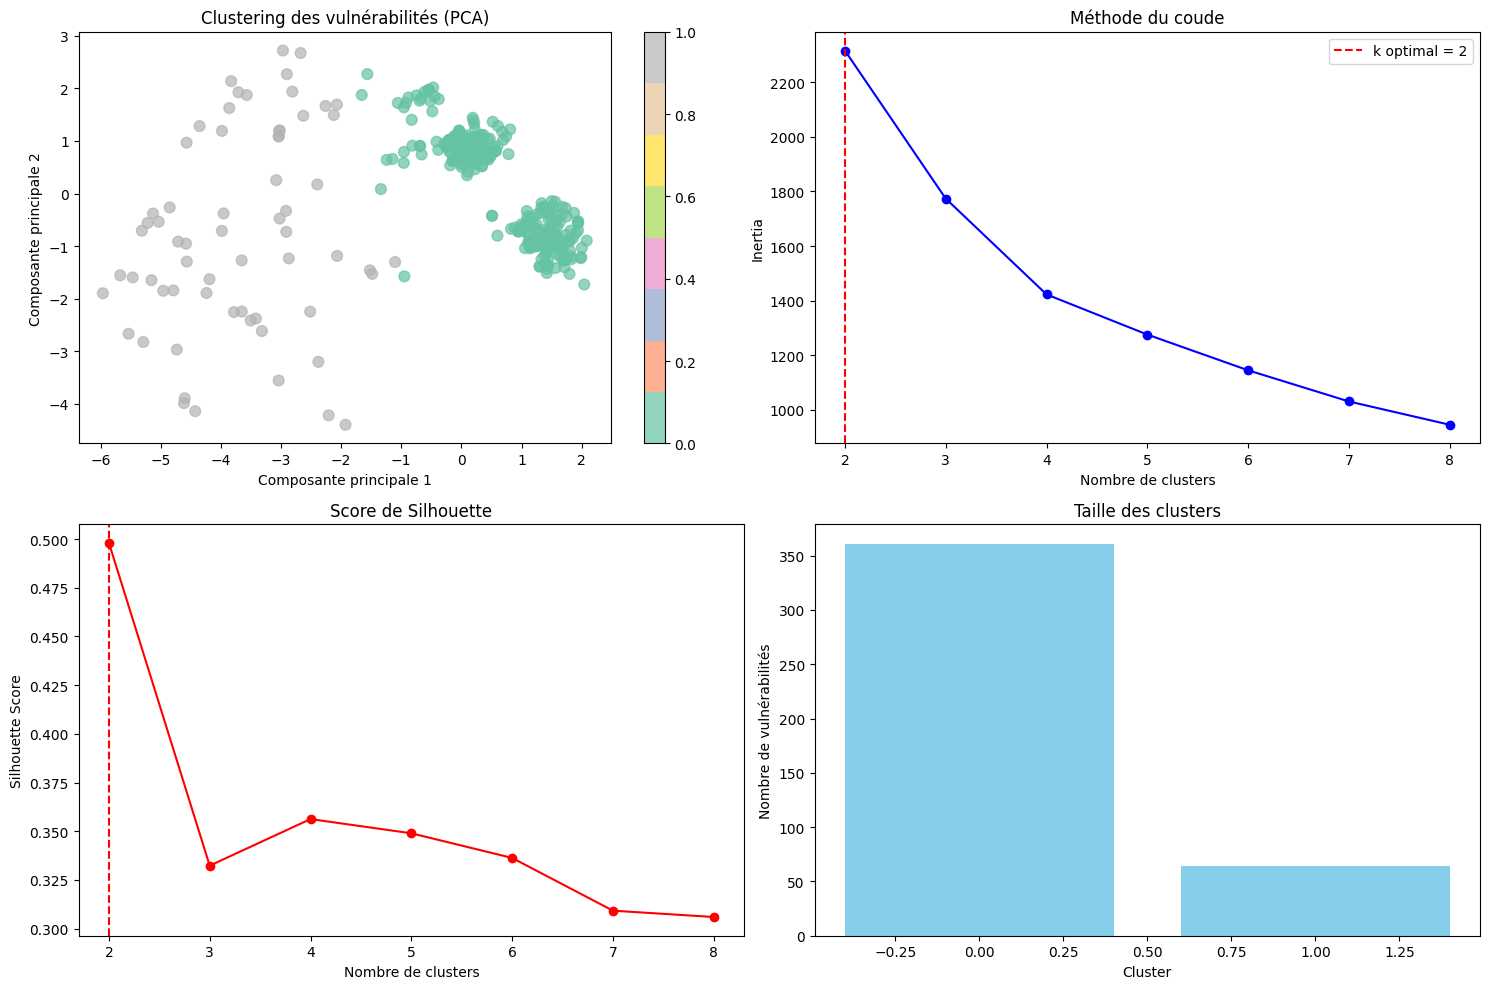


üìä ANALYSE AVANC√âE DES GROUPES DE VULN√âRABILIT√âS

üîç GROUPE 1 : 361 vuln√©rabilit√©s (84.9%)
----------------------------------------------------------------------
üìà PROFIL DE RISQUE D√âTAILL√â :
   ‚Ä¢ Score CVSS moyen : 6.8/10 (m√©diane: 7.3)
   ‚Ä¢ Score EPSS moyen : 0.0312
   ‚Ä¢ S√©v√©rit√© dominante : HIGH (177 cas)
   ‚Ä¢ Type dominant : avis (359 cas)

üè¢ TOP VENDEURS AFFECT√âS :
   1. Microsoft : 70 vuln√©rabilit√©s (19.4%)
   2. SAP_SE : 41 vuln√©rabilit√©s (11.4%)
   3. QNAP Systems Inc. : 21 vuln√©rabilit√©s (5.8%)
   4. Google : 17 vuln√©rabilit√©s (4.7%)
   5. Red Hat : 16 vuln√©rabilit√©s (4.4%)

üõ°Ô∏è TYPES DE VULN√âRABILIT√âS (CWE) :
   1. CWE-416 : 38 cas (10.5%)
   2. CWE-79 : 22 cas (6.1%)
   3. CWE-125 : 18 cas (5.0%)
   4. CWE-862 : 14 cas (3.9%)
   5. CWE-787 : 12 cas (3.3%)

üìÖ √âVOLUTION TEMPORELLE :
   ‚Ä¢ Ann√©es actives : 2024-2025
   ‚Ä¢ Ann√©e la plus active : 2025 (360 vuln√©rabilit√©s)

üí° RECOMMANDATIONS (Score de criticit√©: 12/100) 

In [31]:
# Pr√©paration des donn√©es pour clustering (sur tout le dataset)
df_work = df.copy()

# Encodage des variables cat√©gorielles pour clustering
for col in ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']:
    enc_col = f"{col}_cluster_enc"
    if col in df_work.columns:
        le = LabelEncoder()
        df_work[enc_col] = le.fit_transform(df_work[col].astype(str))

# Conversion des scores num√©riques
df_work['Score CVSS'] = df_work['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
df_work['Score CVSS'] = pd.to_numeric(df_work['Score CVSS'], errors='coerce')
df_work['Score EPSS'] = df_work['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
df_work['Score EPSS'] = pd.to_numeric(df_work['Score EPSS'], errors='coerce')

# **AM√âLIORATION 1 : Features plus discriminantes**
# Ajout de features temporelles et de complexit√©
df_work['Publi√©e le'] = pd.to_datetime(df_work['Publi√©e le'], errors='coerce')
df_work['Ann√©e'] = df_work['Publi√©e le'].dt.year
df_work['Mois'] = df_work['Publi√©e le'].dt.month

# S√©lection des features pour le clustering - VERSION √âTENDUE
features_cluster = [
    'Score CVSS', 'Score EPSS', 'Base Severity_cluster_enc', 'ID CWE_cluster_enc', 
    'Vendeur_cluster_enc', 'Type (Avis ou Alerte)_cluster_enc', 'Ann√©e', 'Mois'
]

# Filtrer les lignes avec toutes les features disponibles
df_cluster = df_work[features_cluster].dropna()

if len(df_cluster) > 10:
    print(f"Donn√©es disponibles pour clustering : {len(df_cluster)} vuln√©rabilit√©s")
    
    # **AM√âLIORATION 2 : M√©thode du coude pour d√©terminer le nombre optimal de clusters**
    from sklearn.metrics import silhouette_score
    
    # Test de diff√©rents nombres de clusters
    max_clusters = min(8, len(df_cluster) // 10)
    if max_clusters < 2:
        max_clusters = 2
        
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    # Standardisation
    scaler_cluster = StandardScaler()
    X_cluster = scaler_cluster.fit_transform(df_cluster)

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_test = kmeans_test.fit_predict(X_cluster)
        inertias.append(kmeans_test.inertia_)
        sil_score = silhouette_score(X_cluster, labels_test)
        silhouette_scores.append(sil_score)
        print(f"k={k}: Silhouette={sil_score:.3f}")

    # Choisir le k optimal (meilleur silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nüéØ Nombre optimal de clusters : {optimal_k} (Silhouette: {max(silhouette_scores):.3f})")

    # **AM√âLIORATION 3 : Clustering final avec le k optimal**
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)

    # R√©duction de dimension pour visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cluster)
    
    df_cluster['cluster'] = labels
    df_work_indexed = df_work.loc[df_cluster.index].copy()
    df_work_indexed['cluster'] = labels

    # **AM√âLIORATION 4 : Visualisation enrichie**
    plt.figure(figsize=(15, 10))
    
    # Graphique principal
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', s=60, alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Clustering des vuln√©rabilit√©s (PCA)")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    
    # M√©thode du coude
    plt.subplot(2, 2, 2)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertia')
    plt.title('M√©thode du coude')
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'k optimal = {optimal_k}')
    plt.legend()
    
    # Silhouette scores
    plt.subplot(2, 2, 3)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Score de Silhouette')
    plt.axvline(x=optimal_k, color='red', linestyle='--')
    
    # Distribution des clusters
    plt.subplot(2, 2, 4)
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Nombre de vuln√©rabilit√©s')
    plt.title('Taille des clusters')
    
    plt.tight_layout()
    plt.show()

    # === ANALYSE D√âTAILL√âE DES CLUSTERS POUR LE CLIENT ===
    print("\n" + "="*80)
    print("üìä ANALYSE AVANC√âE DES GROUPES DE VULN√âRABILIT√âS")
    print("="*80)

    cluster_summaries = []
    
    for i in range(optimal_k):
        cluster_data = df_work_indexed[df_work_indexed['cluster'] == i]
        print(f"\nüîç GROUPE {i+1} : {len(cluster_data)} vuln√©rabilit√©s ({len(cluster_data)/len(df_work_indexed)*100:.1f}%)")
        print("-" * 70)
        
        if len(cluster_data) > 0:
            # **Caract√©ristiques techniques avanc√©es**
            print("üìà PROFIL DE RISQUE D√âTAILL√â :")
            avg_cvss = cluster_data['Score CVSS'].mean()
            avg_epss = cluster_data['Score EPSS'].mean()
            median_cvss = cluster_data['Score CVSS'].median()
            
            severity_counts = cluster_data['Base Severity'].value_counts()
            type_counts = cluster_data['Type (Avis ou Alerte)'].value_counts()
            
            print(f"   ‚Ä¢ Score CVSS moyen : {avg_cvss:.1f}/10 (m√©diane: {median_cvss:.1f})")
            print(f"   ‚Ä¢ Score EPSS moyen : {avg_epss:.4f}")
            print(f"   ‚Ä¢ S√©v√©rit√© dominante : {severity_counts.index[0]} ({severity_counts.iloc[0]} cas)")
            print(f"   ‚Ä¢ Type dominant : {type_counts.index[0]} ({type_counts.iloc[0]} cas)")
            
            # **Top vendeurs avec pourcentages**
            print("\nüè¢ TOP VENDEURS AFFECT√âS :")
            top_vendors = cluster_data['Vendeur'].value_counts().head(5)
            for j, (vendor, count) in enumerate(top_vendors.items(), 1):
                pct = count/len(cluster_data)*100
                print(f"   {j}. {vendor} : {count} vuln√©rabilit√©s ({pct:.1f}%)")
            
            # **Analyse CWE avec descriptions**
            print("\nüõ°Ô∏è TYPES DE VULN√âRABILIT√âS (CWE) :")
            top_cwes = cluster_data['ID CWE'].value_counts().head(5)
            for j, (cwe, count) in enumerate(top_cwes.items(), 1):
                if cwe != 'Non disponible' and cwe != 'Unknown':
                    pct = count/len(cluster_data)*100
                    print(f"   {j}. {cwe} : {count} cas ({pct:.1f}%)")
            
            # **√âvolution temporelle**
            print("\nüìÖ √âVOLUTION TEMPORELLE :")
            if 'Ann√©e' in cluster_data.columns:
                yearly_counts = cluster_data['Ann√©e'].value_counts().sort_index()
                print(f"   ‚Ä¢ Ann√©es actives : {yearly_counts.index.min()}-{yearly_counts.index.max()}")
                print(f"   ‚Ä¢ Ann√©e la plus active : {yearly_counts.idxmax()} ({yearly_counts.max()} vuln√©rabilit√©s)")
            
            # **Calcul du niveau de criticit√© du cluster**
            criticality_score = 0
            if avg_cvss >= 9.0:
                criticality_score += 40
            elif avg_cvss >= 7.0:
                criticality_score += 25
            elif avg_cvss >= 4.0:
                criticality_score += 10
                
            if avg_epss > 0.5:
                criticality_score += 30
            elif avg_epss > 0.1:
                criticality_score += 15
                
            critical_count = len(cluster_data[cluster_data['Base Severity'] == 'CRITICAL'])
            criticality_score += (critical_count / len(cluster_data)) * 30
            
            cluster_summaries.append({
                'cluster': i+1,
                'size': len(cluster_data),
                'avg_cvss': avg_cvss,
                'avg_epss': avg_epss,
                'criticality_score': criticality_score,
                'top_vendor': top_vendors.index[0] if len(top_vendors) > 0 else 'N/A',
                'top_cwe': top_cwes.index[0] if len(top_cwes) > 0 else 'N/A'
            })
            
            # **Recommandations sp√©cifiques am√©lior√©es**
            print(f"\nüí° RECOMMANDATIONS (Score de criticit√©: {criticality_score:.0f}/100) :")
            
            if criticality_score >= 70:
                print("   üî¥ PRIORIT√â MAXIMALE - Action imm√©diate requise")
                print("   üö® Surveillance 24/7 recommand√©e")
            elif criticality_score >= 50:
                print("   üü° PRIORIT√â √âLEV√âE - Traitement dans les 48h")
                print("   üìä Surveillance renforc√©e recommand√©e")
            elif criticality_score >= 30:
                print("   üü¢ PRIORIT√â MOD√âR√âE - Traitement sous 1 semaine")
                print("   üìà Surveillance normale")
            else:
                print("   ‚ö™ PRIORIT√â FAIBLE - Surveillance passive")
            
            # Actions sp√©cifiques
            if len(top_vendors) > 0 and top_vendors.iloc[0] > len(cluster_data) * 0.4:
                print(f"   üéØ Focus vendeur : Concentrer sur {top_vendors.index[0]}")
                
            if 'CRITICAL' in severity_counts.index and severity_counts['CRITICAL'] > 0:
                print(f"   ‚ö†Ô∏è {severity_counts['CRITICAL']} vuln√©rabilit√©s critiques d√©tect√©es")

    # === TABLEAU DE BORD EX√âCUTIF ===
    print("\n" + "="*80)
    print("üìã TABLEAU DE BORD EX√âCUTIF")
    print("="*80)
    
    summary_df = pd.DataFrame(cluster_summaries)
    summary_df = summary_df.sort_values('criticality_score', ascending=False)
    
    print("\nCLASSEMENT DES GROUPES PAR CRITICIT√â :")
    for _, row in summary_df.iterrows():
        print(f"üèÜ Groupe {row['cluster']} | Score: {row['criticality_score']:.0f}/100 | "
              f"Taille: {row['size']} | CVSS: {row['avg_cvss']:.1f} | "
              f"Vendeur dominant: {row['top_vendor']}")
    
    print(f"\nüéØ ACTIONS PRIORITAIRES :")
    top_cluster = summary_df.iloc[0]
    print(f"   1. Traiter en priorit√© le Groupe {top_cluster['cluster']} ({top_cluster['size']} vuln√©rabilit√©s)")
    print(f"   2. Focus sur le vendeur {top_cluster['top_vendor']}")
    print(f"   3. Surveiller l'√©volution des scores EPSS")
    
    # Qualit√© globale du clustering
    final_sil_score = silhouette_score(X_cluster, labels)
    print(f"\nüìä QUALIT√â DE L'ANALYSE : Score de coh√©rence = {final_sil_score:.3f}")
    if final_sil_score > 0.5:
        print("   ‚úÖ Groupes bien distincts - Analyse fiable")
        print("   üìà Recommandation : Utiliser cette segmentation pour la strat√©gie")
    elif final_sil_score > 0.25:
        print("   ‚ö†Ô∏è Groupes mod√©r√©ment distincts - Analyse indicative")
        print("   üìä Recommandation : Compl√©ter avec analyse manuelle")
    else:
        print("   ‚ùå Groupes peu distincts - Analyser avec pr√©caution")
        print("   üîç Recommandation : Revoir les crit√®res de clustering")

else:
    print("‚ùå Pas assez de donn√©es pour r√©aliser l'analyse de clustering.")

## 5. Application d‚Äôun Mod√®le Non Supervis√© pour Regroupement Th√©matique

On applique une r√©duction de dimension (PCA) suivie d‚Äôun clustering KMeans pour regrouper les vuln√©rabilit√©s selon leurs caract√©ristiques.  
On interpr√®te les clusters pour identifier des th√©matiques (familles de produits, types d‚Äôattaque...).

Donn√©es disponibles pour clustering : 425 vuln√©rabilit√©s
k=2: Silhouette=0.498
k=3: Silhouette=0.332
k=4: Silhouette=0.356
k=5: Silhouette=0.349
k=6: Silhouette=0.336
k=7: Silhouette=0.309
k=8: Silhouette=0.306

üéØ Nombre optimal de clusters : 2 (Silhouette: 0.498)


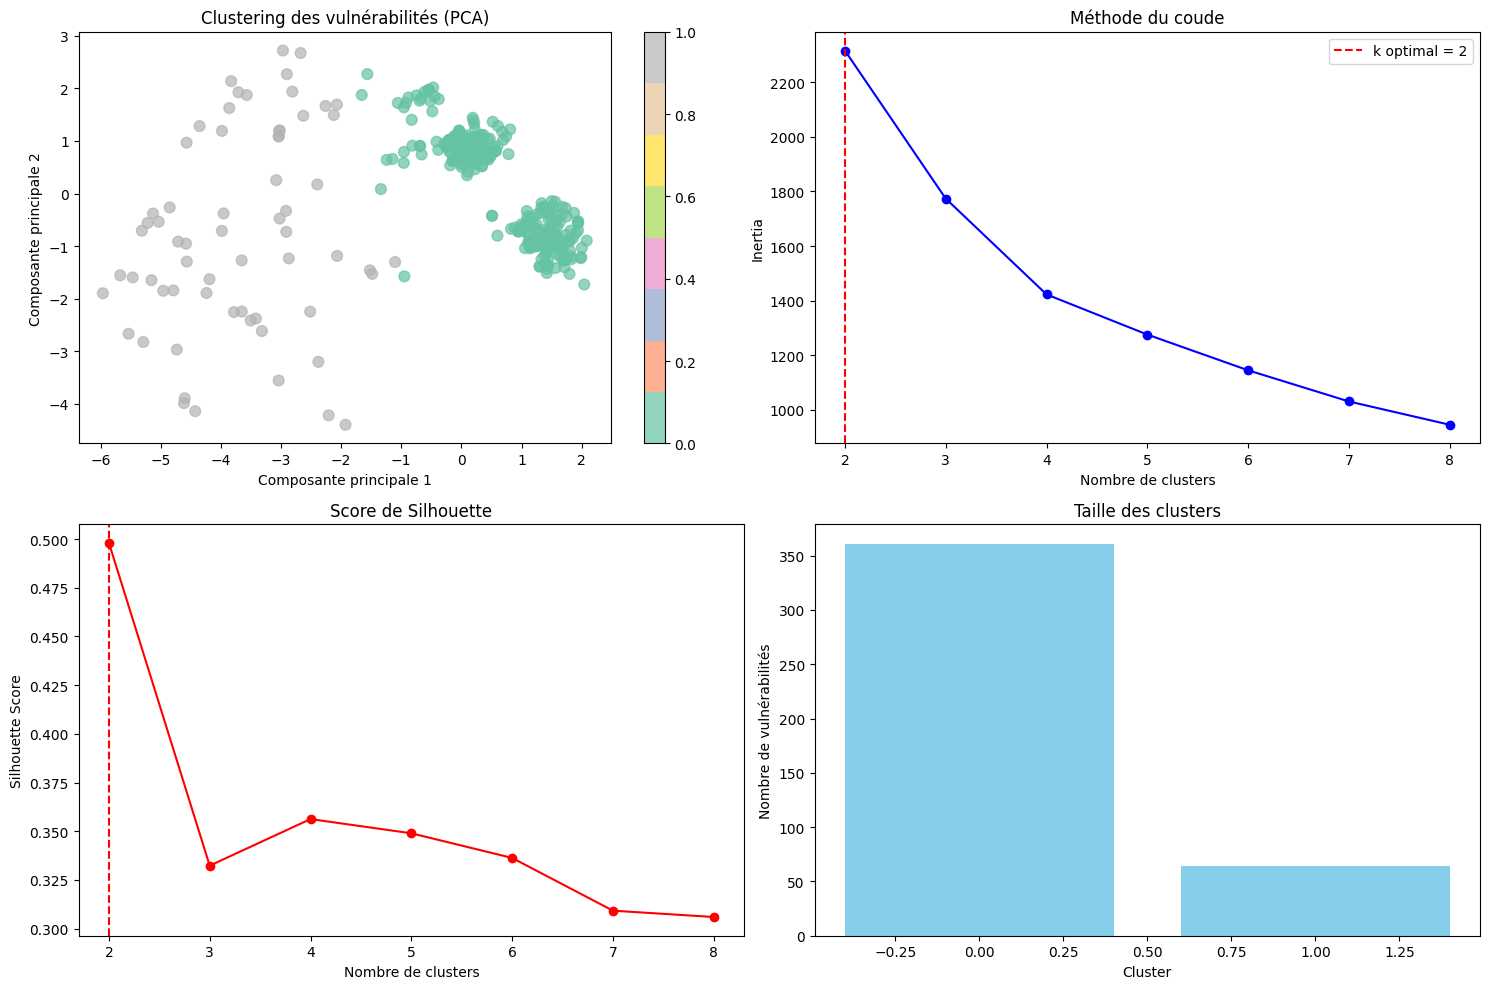


üìä ANALYSE AVANC√âE DES GROUPES DE VULN√âRABILIT√âS

üîç GROUPE 1 : 361 vuln√©rabilit√©s (84.9%)
----------------------------------------------------------------------
üìà PROFIL DE RISQUE D√âTAILL√â :
   ‚Ä¢ Score CVSS moyen : 6.8/10 (m√©diane: 7.3)
   ‚Ä¢ Score EPSS moyen : 0.0312
   ‚Ä¢ S√©v√©rit√© dominante : HIGH (177 cas)
   ‚Ä¢ Type dominant : avis (359 cas)

üè¢ TOP VENDEURS AFFECT√âS :
   1. Microsoft : 70 vuln√©rabilit√©s (19.4%)
   2. SAP_SE : 41 vuln√©rabilit√©s (11.4%)
   3. QNAP Systems Inc. : 21 vuln√©rabilit√©s (5.8%)
   4. Google : 17 vuln√©rabilit√©s (4.7%)
   5. Red Hat : 16 vuln√©rabilit√©s (4.4%)

üõ°Ô∏è TYPES DE VULN√âRABILIT√âS (CWE) :
   1. CWE-416 : 38 cas (10.5%)
   2. CWE-79 : 22 cas (6.1%)
   3. CWE-125 : 18 cas (5.0%)
   4. CWE-862 : 14 cas (3.9%)
   5. CWE-787 : 12 cas (3.3%)

üìÖ √âVOLUTION TEMPORELLE :
   ‚Ä¢ Ann√©es actives : 2024-2025
   ‚Ä¢ Ann√©e la plus active : 2025 (360 vuln√©rabilit√©s)

üí° RECOMMANDATIONS (Score de criticit√©: 12/100) 

In [32]:
# Pr√©paration des donn√©es pour clustering (sur tout le dataset)
df_work = df.copy()

# Encodage des variables cat√©gorielles pour clustering
for col in ['Base Severity', 'ID CWE', 'Vendeur', 'Type (Avis ou Alerte)']:
    enc_col = f"{col}_cluster_enc"
    if col in df_work.columns:
        le = LabelEncoder()
        df_work[enc_col] = le.fit_transform(df_work[col].astype(str))

# Conversion des scores num√©riques
df_work['Score CVSS'] = df_work['Score CVSS'].replace(['Pas de Score CVSS', 'Non disponible', ''], np.nan)
df_work['Score CVSS'] = pd.to_numeric(df_work['Score CVSS'], errors='coerce')
df_work['Score EPSS'] = df_work['Score EPSS'].replace(['Pas de Score EPSS', 'Non disponible', ''], np.nan)
df_work['Score EPSS'] = pd.to_numeric(df_work['Score EPSS'], errors='coerce')

# **AM√âLIORATION 1 : Features plus discriminantes**
# Ajout de features temporelles et de complexit√©
df_work['Publi√©e le'] = pd.to_datetime(df_work['Publi√©e le'], errors='coerce')
df_work['Ann√©e'] = df_work['Publi√©e le'].dt.year
df_work['Mois'] = df_work['Publi√©e le'].dt.month

# S√©lection des features pour le clustering - VERSION √âTENDUE
features_cluster = [
    'Score CVSS', 'Score EPSS', 'Base Severity_cluster_enc', 'ID CWE_cluster_enc', 
    'Vendeur_cluster_enc', 'Type (Avis ou Alerte)_cluster_enc', 'Ann√©e', 'Mois'
]

# Filtrer les lignes avec toutes les features disponibles
df_cluster = df_work[features_cluster].dropna()

if len(df_cluster) > 10:
    print(f"Donn√©es disponibles pour clustering : {len(df_cluster)} vuln√©rabilit√©s")
    
    # **AM√âLIORATION 2 : M√©thode du coude pour d√©terminer le nombre optimal de clusters**
    from sklearn.metrics import silhouette_score
    
    # Test de diff√©rents nombres de clusters
    max_clusters = min(8, len(df_cluster) // 10)
    if max_clusters < 2:
        max_clusters = 2
        
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    # Standardisation
    scaler_cluster = StandardScaler()
    X_cluster = scaler_cluster.fit_transform(df_cluster)

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_test = kmeans_test.fit_predict(X_cluster)
        inertias.append(kmeans_test.inertia_)
        sil_score = silhouette_score(X_cluster, labels_test)
        silhouette_scores.append(sil_score)
        print(f"k={k}: Silhouette={sil_score:.3f}")

    # Choisir le k optimal (meilleur silhouette score)
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nüéØ Nombre optimal de clusters : {optimal_k} (Silhouette: {max(silhouette_scores):.3f})")

    # **AM√âLIORATION 3 : Clustering final avec le k optimal**
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)

    # R√©duction de dimension pour visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cluster)
    
    df_cluster['cluster'] = labels
    df_work_indexed = df_work.loc[df_cluster.index].copy()
    df_work_indexed['cluster'] = labels

    # **AM√âLIORATION 4 : Visualisation enrichie**
    plt.figure(figsize=(15, 10))
    
    # Graphique principal
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', s=60, alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Clustering des vuln√©rabilit√©s (PCA)")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    
    # M√©thode du coude
    plt.subplot(2, 2, 2)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertia')
    plt.title('M√©thode du coude')
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'k optimal = {optimal_k}')
    plt.legend()
    
    # Silhouette scores
    plt.subplot(2, 2, 3)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Score de Silhouette')
    plt.axvline(x=optimal_k, color='red', linestyle='--')
    
    # Distribution des clusters
    plt.subplot(2, 2, 4)
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Nombre de vuln√©rabilit√©s')
    plt.title('Taille des clusters')
    
    plt.tight_layout()
    plt.show()

    # === ANALYSE D√âTAILL√âE DES CLUSTERS POUR LE CLIENT ===
    print("\n" + "="*80)
    print("üìä ANALYSE AVANC√âE DES GROUPES DE VULN√âRABILIT√âS")
    print("="*80)

    cluster_summaries = []
    
    for i in range(optimal_k):
        cluster_data = df_work_indexed[df_work_indexed['cluster'] == i]
        print(f"\nüîç GROUPE {i+1} : {len(cluster_data)} vuln√©rabilit√©s ({len(cluster_data)/len(df_work_indexed)*100:.1f}%)")
        print("-" * 70)
        
        if len(cluster_data) > 0:
            # **Caract√©ristiques techniques avanc√©es**
            print("üìà PROFIL DE RISQUE D√âTAILL√â :")
            avg_cvss = cluster_data['Score CVSS'].mean()
            avg_epss = cluster_data['Score EPSS'].mean()
            median_cvss = cluster_data['Score CVSS'].median()
            
            severity_counts = cluster_data['Base Severity'].value_counts()
            type_counts = cluster_data['Type (Avis ou Alerte)'].value_counts()
            
            print(f"   ‚Ä¢ Score CVSS moyen : {avg_cvss:.1f}/10 (m√©diane: {median_cvss:.1f})")
            print(f"   ‚Ä¢ Score EPSS moyen : {avg_epss:.4f}")
            print(f"   ‚Ä¢ S√©v√©rit√© dominante : {severity_counts.index[0]} ({severity_counts.iloc[0]} cas)")
            print(f"   ‚Ä¢ Type dominant : {type_counts.index[0]} ({type_counts.iloc[0]} cas)")
            
            # **Top vendeurs avec pourcentages**
            print("\nüè¢ TOP VENDEURS AFFECT√âS :")
            top_vendors = cluster_data['Vendeur'].value_counts().head(5)
            for j, (vendor, count) in enumerate(top_vendors.items(), 1):
                pct = count/len(cluster_data)*100
                print(f"   {j}. {vendor} : {count} vuln√©rabilit√©s ({pct:.1f}%)")
            
            # **Analyse CWE avec descriptions**
            print("\nüõ°Ô∏è TYPES DE VULN√âRABILIT√âS (CWE) :")
            top_cwes = cluster_data['ID CWE'].value_counts().head(5)
            for j, (cwe, count) in enumerate(top_cwes.items(), 1):
                if cwe != 'Non disponible' and cwe != 'Unknown':
                    pct = count/len(cluster_data)*100
                    print(f"   {j}. {cwe} : {count} cas ({pct:.1f}%)")
            
            # **√âvolution temporelle**
            print("\nüìÖ √âVOLUTION TEMPORELLE :")
            if 'Ann√©e' in cluster_data.columns:
                yearly_counts = cluster_data['Ann√©e'].value_counts().sort_index()
                print(f"   ‚Ä¢ Ann√©es actives : {yearly_counts.index.min()}-{yearly_counts.index.max()}")
                print(f"   ‚Ä¢ Ann√©e la plus active : {yearly_counts.idxmax()} ({yearly_counts.max()} vuln√©rabilit√©s)")
            
            # **Calcul du niveau de criticit√© du cluster**
            criticality_score = 0
            if avg_cvss >= 9.0:
                criticality_score += 40
            elif avg_cvss >= 7.0:
                criticality_score += 25
            elif avg_cvss >= 4.0:
                criticality_score += 10
                
            if avg_epss > 0.5:
                criticality_score += 30
            elif avg_epss > 0.1:
                criticality_score += 15
                
            critical_count = len(cluster_data[cluster_data['Base Severity'] == 'CRITICAL'])
            criticality_score += (critical_count / len(cluster_data)) * 30
            
            cluster_summaries.append({
                'cluster': i+1,
                'size': len(cluster_data),
                'avg_cvss': avg_cvss,
                'avg_epss': avg_epss,
                'criticality_score': criticality_score,
                'top_vendor': top_vendors.index[0] if len(top_vendors) > 0 else 'N/A',
                'top_cwe': top_cwes.index[0] if len(top_cwes) > 0 else 'N/A'
            })
            
            # **Recommandations sp√©cifiques am√©lior√©es**
            print(f"\nüí° RECOMMANDATIONS (Score de criticit√©: {criticality_score:.0f}/100) :")
            
            if criticality_score >= 70:
                print("   üî¥ PRIORIT√â MAXIMALE - Action imm√©diate requise")
                print("   üö® Surveillance 24/7 recommand√©e")
            elif criticality_score >= 50:
                print("   üü° PRIORIT√â √âLEV√âE - Traitement dans les 48h")
                print("   üìä Surveillance renforc√©e recommand√©e")
            elif criticality_score >= 30:
                print("   üü¢ PRIORIT√â MOD√âR√âE - Traitement sous 1 semaine")
                print("   üìà Surveillance normale")
            else:
                print("   ‚ö™ PRIORIT√â FAIBLE - Surveillance passive")
            
            # Actions sp√©cifiques
            if len(top_vendors) > 0 and top_vendors.iloc[0] > len(cluster_data) * 0.4:
                print(f"   üéØ Focus vendeur : Concentrer sur {top_vendors.index[0]}")
                
            if 'CRITICAL' in severity_counts.index and severity_counts['CRITICAL'] > 0:
                print(f"   ‚ö†Ô∏è {severity_counts['CRITICAL']} vuln√©rabilit√©s critiques d√©tect√©es")

    # === TABLEAU DE BORD EX√âCUTIF ===
    print("\n" + "="*80)
    print("üìã TABLEAU DE BORD EX√âCUTIF")
    print("="*80)
    
    summary_df = pd.DataFrame(cluster_summaries)
    summary_df = summary_df.sort_values('criticality_score', ascending=False)
    
    print("\nCLASSEMENT DES GROUPES PAR CRITICIT√â :")
    for _, row in summary_df.iterrows():
        print(f"üèÜ Groupe {row['cluster']} | Score: {row['criticality_score']:.0f}/100 | "
              f"Taille: {row['size']} | CVSS: {row['avg_cvss']:.1f} | "
              f"Vendeur dominant: {row['top_vendor']}")
    
    print(f"\nüéØ ACTIONS PRIORITAIRES :")
    top_cluster = summary_df.iloc[0]
    print(f"   1. Traiter en priorit√© le Groupe {top_cluster['cluster']} ({top_cluster['size']} vuln√©rabilit√©s)")
    print(f"   2. Focus sur le vendeur {top_cluster['top_vendor']}")
    print(f"   3. Surveiller l'√©volution des scores EPSS")
    
    # Qualit√© globale du clustering
    final_sil_score = silhouette_score(X_cluster, labels)
    print(f"\nüìä QUALIT√â DE L'ANALYSE : Score de coh√©rence = {final_sil_score:.3f}")
    if final_sil_score > 0.5:
        print("   ‚úÖ Groupes bien distincts - Analyse fiable")
        print("   üìà Recommandation : Utiliser cette segmentation pour la strat√©gie")
    elif final_sil_score > 0.25:
        print("   ‚ö†Ô∏è Groupes mod√©r√©ment distincts - Analyse indicative")
        print("   üìä Recommandation : Compl√©ter avec analyse manuelle")
    else:
        print("   ‚ùå Groupes peu distincts - Analyser avec pr√©caution")
        print("   üîç Recommandation : Revoir les crit√®res de clustering")

else:
    print("‚ùå Pas assez de donn√©es pour r√©aliser l'analyse de clustering.")

## 6. Validation et Visualisation des Mod√®les

On √©value la performance du mod√®le supervis√© (pr√©diction de la date de fin de menace) et la qualit√© du clustering non supervis√©.


VALIDATION DES MOD√àLES

üìä VALIDATION DU MOD√àLE DE PR√âDICTION DE DUR√âE :
   ‚Ä¢ RMSE : 29.3 jours
   ‚Ä¢ R¬≤ Score : 0.747
   ‚Ä¢ Erreur Absolue Moyenne : 22.7 jours
   ‚úÖ Mod√®le performant


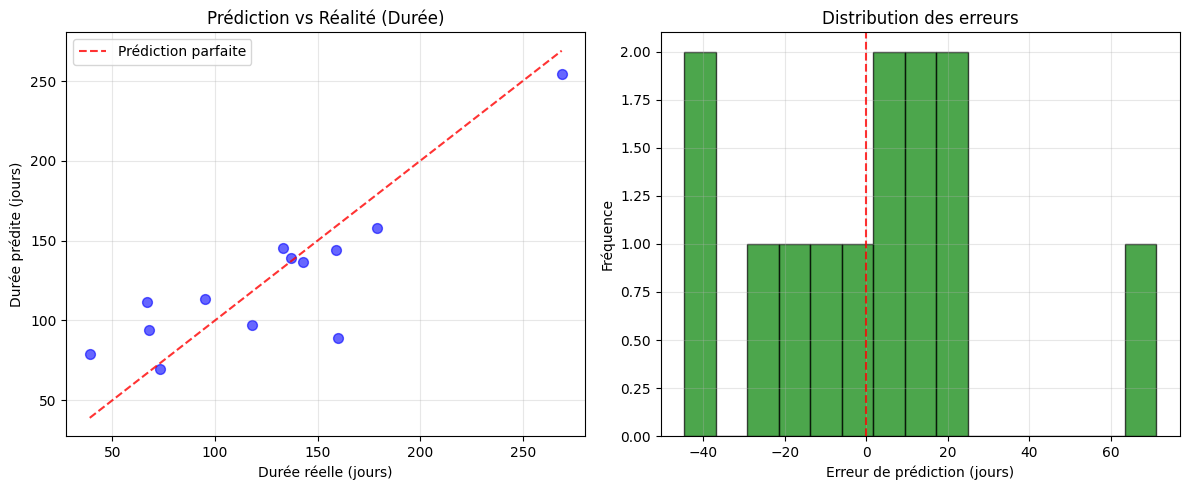


üìà IMPORTANCE DES VARIABLES :
   ‚Ä¢ Vendeur_enc: 0.593
   ‚Ä¢ Score EPSS: 0.170
   ‚Ä¢ Score CVSS: 0.111
   ‚Ä¢ ID CWE_enc: 0.092
   ‚Ä¢ Base Severity_enc: 0.033
   ‚Ä¢ Type (Avis ou Alerte)_enc: 0.000

üìä VALIDATION DU CLUSTERING :
   ‚Ä¢ Silhouette score (donn√©es normalis√©es) : 0.498
   ‚Ä¢ Silhouette score (PCA) : 0.655
   ‚úÖ Clustering de tr√®s bonne qualit√©

üìã STATISTIQUES DES CLUSTERS :
   ‚Ä¢ Nombre de clusters : 2
   ‚Ä¢ Taille moyenne des clusters : 212.5
   ‚Ä¢ √âcart-type des tailles : 148.5
   ‚Ä¢ Cluster 1: 361 √©l√©ments (84.9%)
   ‚Ä¢ Cluster 2: 64 √©l√©ments (15.1%)

üìã SYNTH√àSE DE LA VALIDATION
   ‚úÖ Mod√®le de pr√©diction : Performant
   ‚úÖ Clustering : Tr√®s bonne qualit√©

üí° RECOMMANDATIONS :

‚úÖ Validation termin√©e


In [33]:
# 5. Validation et Visualisation des Mod√®les

print("\n" + "="*50)
print("VALIDATION DES MOD√àLES")
print("="*50)

# Validation du mod√®le supervis√© (pr√©diction de la dur√©e)
if 'df_train' in locals() and not df_train.empty and len(df_train) >= 4:
    print("\nüìä VALIDATION DU MOD√àLE DE PR√âDICTION DE DUR√âE :")
    
    # Utiliser la dur√©e en jours comme variable cible
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
        df_train[features], 
        df_train['duree_alerte_jours'], 
        test_size=0.2, 
        random_state=42
    )
    
    scaler_val = StandardScaler()
    X_train_scaled = scaler_val.fit_transform(X_train_val)
    X_test_scaled = scaler_val.transform(X_test_val)
    
    rf_val = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_val.fit(X_train_scaled, y_train_val)
    y_pred_test = rf_val.predict(X_test_scaled)
    
    # M√©triques de performance
    mse = mean_squared_error(y_test_val, y_pred_test)
    r2 = r2_score(y_test_val, y_pred_test)
    mae = np.mean(np.abs(y_test_val - y_pred_test))
    
    print(f"   ‚Ä¢ RMSE : {np.sqrt(mse):.1f} jours")
    print(f"   ‚Ä¢ R¬≤ Score : {r2:.3f}")
    print(f"   ‚Ä¢ Erreur Absolue Moyenne : {mae:.1f} jours")
    
    # Interpr√©tation des r√©sultats
    if r2 > 0.7:
        print("   ‚úÖ Mod√®le performant")
    elif r2 > 0.4:
        print("   ‚ö†Ô∏è Mod√®le acceptable")
    else:
        print("   ‚ùå Mod√®le peu fiable")

    # Visualisation des pr√©dictions vs vraies valeurs
    plt.figure(figsize=(12, 5))
    
    # Graphique 1: Scatter plot pr√©dictions vs r√©alit√©
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_val, y_pred_test, alpha=0.6, color='blue', s=50)
    plt.xlabel("Dur√©e r√©elle (jours)")
    plt.ylabel("Dur√©e pr√©dite (jours)")
    plt.title("Pr√©diction vs R√©alit√© (Dur√©e)")
    
    # Ligne de r√©f√©rence parfaite
    min_val = min(y_test_val.min(), y_pred_test.min())
    max_val = max(y_test_val.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Pr√©diction parfaite')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Graphique 2: Distribution des erreurs
    plt.subplot(1, 2, 2)
    errors = y_test_val - y_pred_test
    plt.hist(errors, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    plt.xlabel("Erreur de pr√©diction (jours)")
    plt.ylabel("Fr√©quence")
    plt.title("Distribution des erreurs")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Importance des features
    if hasattr(rf_val, 'feature_importances_'):
        print("\nüìà IMPORTANCE DES VARIABLES :")
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': rf_val.feature_importances_
        }).sort_values('importance', ascending=False)
        
        for _, row in feature_importance.iterrows():
            print(f"   ‚Ä¢ {row['feature']}: {row['importance']:.3f}")

elif 'df_train' in locals() and len(df_train) < 4:
    print("\n‚ö†Ô∏è Pas assez de donn√©es pour la validation (minimum 4 √©chantillons requis)")
    print(f"   Donn√©es disponibles : {len(df_train) if 'df_train' in locals() else 0}")
else:
    print("\n‚ùå Aucune donn√©e d'entra√Ænement disponible pour la validation")

# Validation du clustering (silhouette score)
print("\nüìä VALIDATION DU CLUSTERING :")
if 'labels' in locals() and len(set(labels)) > 1:
    if 'X_cluster' in locals():
        sil_score = silhouette_score(X_cluster, labels)
        print(f"   ‚Ä¢ Silhouette score (donn√©es normalis√©es) : {sil_score:.3f}")
    
    if 'X_pca' in locals():
        sil_score_pca = silhouette_score(X_pca, labels)
        print(f"   ‚Ä¢ Silhouette score (PCA) : {sil_score_pca:.3f}")
    
    # Interpr√©tation du score
    best_score = max(sil_score if 'sil_score' in locals() else 0, 
                    sil_score_pca if 'sil_score_pca' in locals() else 0)
    
    if best_score > 0.5:
        print("   ‚úÖ Clustering de tr√®s bonne qualit√©")
    elif best_score > 0.25:
        print("   ‚ö†Ô∏è Clustering de qualit√© acceptable")
    else:
        print("   ‚ùå Clustering de faible qualit√©")
        
    # Statistiques des clusters
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\nüìã STATISTIQUES DES CLUSTERS :")
    print(f"   ‚Ä¢ Nombre de clusters : {len(unique_labels)}")
    print(f"   ‚Ä¢ Taille moyenne des clusters : {np.mean(counts):.1f}")
    print(f"   ‚Ä¢ √âcart-type des tailles : {np.std(counts):.1f}")
    
    # Distribution des tailles
    for i, (label, count) in enumerate(zip(unique_labels, counts)):
        pct = count / len(labels) * 100
        print(f"   ‚Ä¢ Cluster {label + 1}: {count} √©l√©ments ({pct:.1f}%)")

elif 'labels' in locals() and len(set(labels)) == 1:
    print("   ‚ùå Impossible de calculer le silhouette score (un seul cluster)")
    print("   üí° Suggestion : Revoir les param√®tres de clustering")
else:
    print("   ‚ùå Aucun clustering disponible pour la validation")

# Synth√®se globale de la validation
print("\n" + "="*50)
print("üìã SYNTH√àSE DE LA VALIDATION")
print("="*50)

validation_results = []

# R√©sultat du mod√®le supervis√©
if 'r2' in locals():
    if r2 > 0.7:
        validation_results.append("‚úÖ Mod√®le de pr√©diction : Performant")
    elif r2 > 0.4:
        validation_results.append("‚ö†Ô∏è Mod√®le de pr√©diction : Acceptable")
    else:
        validation_results.append("‚ùå Mod√®le de pr√©diction : √Ä am√©liorer")
else:
    validation_results.append("‚ùì Mod√®le de pr√©diction : Non √©valu√©")

# R√©sultat du clustering
if 'best_score' in locals():
    if best_score > 0.5:
        validation_results.append("‚úÖ Clustering : Tr√®s bonne qualit√©")
    elif best_score > 0.25:
        validation_results.append("‚ö†Ô∏è Clustering : Qualit√© acceptable")
    else:
        validation_results.append("‚ùå Clustering : √Ä am√©liorer")
else:
    validation_results.append("‚ùì Clustering : Non √©valu√©")

for result in validation_results:
    print(f"   {result}")

# Recommandations
print(f"\nüí° RECOMMANDATIONS :")
if 'r2' in locals() and r2 < 0.4:
    print("   ‚Ä¢ Collecter plus de donn√©es historiques pour am√©liorer le mod√®le")
    print("   ‚Ä¢ Ajouter des features explicatives (ex: complexit√© technique)")
if 'best_score' in locals() and best_score < 0.25:
    print("   ‚Ä¢ Revoir les features utilis√©es pour le clustering")
    print("   ‚Ä¢ Tester diff√©rents algorithmes de clustering")
if len(validation_results) < 2:
    print("   ‚Ä¢ Assurer une collecte de donn√©es suffisante pour les validations")

print("\n‚úÖ Validation termin√©e")

## 7. D√©tection et G√©n√©ration d'Alertes Critiques

On filtre les vuln√©rabilit√©s critiques (score CVSS √©lev√© ou s√©v√©rit√© critique, date de fin proche ou d√©pass√©e), on extrait les informations cl√©s, et on pr√©pare le message d‚Äôalerte.

In [34]:
# D√©finition des crit√®res de criticit√©
critical_cvss = 9.0
critical_severity = 'CRITICAL'
now = pd.Timestamp.now()

# V√©rifier les noms des colonnes disponibles
print("Colonnes disponibles dans le DataFrame :")
print(list(df.columns))

# CORRECTION : Standardiser les timezones pour √©viter les conflits
df['Publi√©e le'] = pd.to_datetime(df['Publi√©e le']).dt.tz_localize(None)
df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"]).dt.tz_localize(None)

# Utiliser les vrais noms de colonnes
df['base_severity_upper'] = df['Base Severity'].str.upper()
df['days_to_end'] = (df["Date de fin d'alerte"] - now).dt.days

# Crit√®res de criticit√© : 
# 1. Score CVSS >= 9.0 OU S√©v√©rit√© = CRITICAL
# 2. ET (Date de fin dans les 7 prochains jours OU d√©j√† d√©pass√©e OU date manquante)
crit_mask = (
    (pd.notna(df['Score CVSS']) & (df['Score CVSS'] >= critical_cvss)) |
    (df['base_severity_upper'] == critical_severity)
) & (
    (pd.isna(df["Date de fin d'alerte"])) |  # Date manquante = critique
    (df['days_to_end'] <= 7)  # Date proche ou d√©pass√©e
)

df_crit = df[crit_mask].copy()

print(f"Nombre de vuln√©rabilit√©s critiques d√©tect√©es : {len(df_crit)}")

if not df_crit.empty:
    # CORRECTION : Utiliser les vrais noms de colonnes pour l'affichage
    colonnes_affichage = ['ID CVE', 'Titre', 'Score CVSS', 'Base Severity', 
                         "Date de fin d'alerte", 'Vendeur', 'Lien']
    
    # V√©rifier que toutes les colonnes existent
    colonnes_existantes = [col for col in colonnes_affichage if col in df_crit.columns]
    print(f"\nColonnes d'affichage disponibles : {colonnes_existantes}")
    
    if colonnes_existantes:
        print("\nüö® VULN√âRABILIT√âS CRITIQUES D√âTECT√âES :")
        print("=" * 80)
        
        # Affichage d√©taill√© des vuln√©rabilit√©s critiques
        for idx, row in df_crit.iterrows():
            print(f"\nüî¥ ALERTE #{idx+1}")
            print("-" * 40)
            
            if 'ID CVE' in df_crit.columns:
                print(f"CVE ID: {row['ID CVE']}")
            if 'Titre' in df_crit.columns:
                print(f"Titre: {row['Titre'][:80]}...")
            if 'Score CVSS' in df_crit.columns:
                cvss_score = row['Score CVSS']
                if pd.notna(cvss_score):
                    print(f"Score CVSS: {cvss_score}/10 ‚ö†Ô∏è")
                else:
                    print("Score CVSS: Non disponible")
            if 'Base Severity' in df_crit.columns:
                print(f"S√©v√©rit√©: {row['Base Severity']}")
            if 'Vendeur' in df_crit.columns:
                print(f"Vendeur: {row['Vendeur']}")
            if "Date de fin d'alerte" in df_crit.columns:
                date_fin = row["Date de fin d'alerte"]
                if pd.notna(date_fin):
                    days_remaining = (date_fin - now).days
                    if days_remaining < 0:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')} ‚ùå D√âPASS√âE de {abs(days_remaining)} jours")
                    elif days_remaining <= 7:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')} ‚è∞ Dans {days_remaining} jours")
                    else:
                        print(f"Date de fin: {date_fin.strftime('%Y-%m-%d')}")
                else:
                    print("Date de fin: NON D√âFINIE ‚ö†Ô∏è")
            if 'Lien' in df_crit.columns:
                print(f"Lien ANSSI: {row['Lien']}")
        
        print("\n" + "=" * 80)
        
        # Statistiques des vuln√©rabilit√©s critiques
        print(f"\nüìä STATISTIQUES DES VULN√âRABILIT√âS CRITIQUES :")
        
        # R√©partition par s√©v√©rit√©
        if 'Base Severity' in df_crit.columns:
            severity_counts = df_crit['Base Severity'].value_counts()
            print("\nüéØ R√©partition par s√©v√©rit√© :")
            for severity, count in severity_counts.items():
                print(f"   ‚Ä¢ {severity}: {count} vuln√©rabilit√©s")
        
        # R√©partition par vendeur
        if 'Vendeur' in df_crit.columns:
            vendor_counts = df_crit['Vendeur'].value_counts().head(5)
            print("\nüè¢ Top 5 des vendeurs affect√©s :")
            for vendor, count in vendor_counts.items():
                print(f"   ‚Ä¢ {vendor}: {count} vuln√©rabilit√©s")
        
        # Vuln√©rabilit√©s avec dates d√©pass√©es
        expired_vulns = df_crit[
            pd.notna(df_crit["Date de fin d'alerte"]) & 
            (df_crit['days_to_end'] < 0)
        ]
        print(f"\n‚è∞ Vuln√©rabilit√©s avec date de fin d√©pass√©e : {len(expired_vulns)}")
        
        # Vuln√©rabilit√©s sans date de fin
        no_date_vulns = df_crit[pd.isna(df_crit["Date de fin d'alerte"])]
        print(f"‚ùì Vuln√©rabilit√©s sans date de fin d√©finie : {len(no_date_vulns)}")
        
    else:
        print("‚ö†Ô∏è Aucune colonne d'affichage disponible")
        print("Colonnes dans df_crit :", list(df_crit.columns))
else:
    print("‚úÖ Aucune vuln√©rabilit√© critique d√©tect√©e selon les crit√®res.")
    print(f"   Crit√®res utilis√©s :")
    print(f"   ‚Ä¢ Score CVSS >= {critical_cvss} OU S√©v√©rit√© = {critical_severity}")
    print(f"   ‚Ä¢ ET (Date de fin dans les 7 prochains jours OU d√©j√† d√©pass√©e OU manquante)")

Colonnes disponibles dans le DataFrame :
['Identifiant ANSSI', 'Titre', 'Type (Avis ou Alerte)', 'Publi√©e le', "Date de fin d'alerte", 'ID CVE', 'Score CVSS', 'Base Severity', 'Score EPSS', 'ID CWE', 'Description CWE', 'Lien', 'Description', 'Vendeur', 'Produit', 'Version Affect√©s', 'Diff√©rence en jours']


ValueError: time data "En cours" doesn't match format "%Y-%m-%d %H:%M:%S%z", at position 15. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [35]:
def send_email(to_email, subject, body):
    # √Ä personnaliser avec vos identifiants r√©els
    from_email = "aitndf@gmail.com"
    password = "qyja rsra yqfe kflh"


    if from_email == "votre_email@gmail.com" or password == "votre_mot_de_passe_application":
        print("\n[SIMULATION EMAIL] (configuration non renseign√©e)")
        print(f"TO: {to_email}\nSUBJECT: {subject}\nBODY:\n{body}\n{'-'*40}")
        return False

    msg = MIMEText(body, 'html')
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(from_email, password)
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        print(f"Email envoy√© √† {to_email}")
        return True
    except Exception as e:
        print(f"Erreur lors de l'envoi de l'email: {e}")
        return False

# Liste des abonn√©s (√† adapter selon vos besoins)
subscribers = ["esssai@gmail.com"]

# CORRECTION : V√©rifier que df_crit existe avant de l'utiliser
if 'df_crit' not in locals():
    print("‚ö†Ô∏è La variable df_crit n'est pas d√©finie. Ex√©cution de la d√©tection des vuln√©rabilit√©s critiques...")
    
    # Recr√©er la d√©tection des vuln√©rabilit√©s critiques
    critical_cvss = 9.0
    critical_severity = 'CRITICAL'
    now = pd.Timestamp.now()
    
    # V√©rifier que df existe
    if 'df' not in locals():
        print("‚ùå Le DataFrame principal 'df' n'est pas charg√©. Veuillez ex√©cuter les cellules pr√©c√©dentes.")
        df_crit = pd.DataFrame()  # DataFrame vide pour √©viter l'erreur
    else:
        # Standardiser les timezones pour √©viter les conflits
        df['Publi√©e le'] = pd.to_datetime(df['Publi√©e le']).dt.tz_localize(None)
        df["Date de fin d'alerte"] = pd.to_datetime(df["Date de fin d'alerte"]).dt.tz_localize(None)
        
        # Utiliser les vrais noms de colonnes
        df['base_severity_upper'] = df['Base Severity'].str.upper()
        df['days_to_end'] = (df["Date de fin d'alerte"] - now).dt.days
        
        # Crit√®res de criticit√©
        crit_mask = (
            (pd.notna(df['Score CVSS']) & (df['Score CVSS'] >= critical_cvss)) |
            (df['base_severity_upper'] == critical_severity)
        ) & (
            (pd.isna(df["Date de fin d'alerte"])) |  # Date manquante = critique
            (df['days_to_end'] <= 7)  # Date proche ou d√©pass√©e
        )
        
        df_crit = df[crit_mask].copy()
        print(f"‚úÖ {len(df_crit)} vuln√©rabilit√©s critiques d√©tect√©es")

# Envoi d'emails pour les vuln√©rabilit√©s critiques
if 'df_crit' in locals() and not df_crit.empty:
    print(f"\nüìß ENVOI D'ALERTES EMAIL POUR {len(df_crit)} VULN√âRABILIT√âS CRITIQUES")
    print("=" * 70)
    
    for idx, row in df_crit.iterrows():
        # CORRECTION : Utiliser les vrais noms de colonnes avec gestion d'erreur
        cve_id = row.get('ID CVE', 'N/A')
        title = row.get('Titre', 'N/A')
        cvss_score = row.get('Score CVSS', 'N/A')
        severity = row.get('Base Severity', 'N/A')
        vendor = row.get('Vendeur', 'N/A')
        date_fin = row.get("Date de fin d'alerte", None)
        link = row.get('Lien', 'N/A')
        
        # Titre court pour le sujet de l'email
        title_short = str(title)[:40] + "..." if len(str(title)) > 40 else str(title)
        subject = f"üö® ALERTE CRITIQUE CVE: {cve_id} - {title_short}"
        
        # Formatage de la date de fin
        date_fin_str = "NON D√âFINIE"
        urgency_level = "üî¥ CRITIQUE"
        
        if pd.notna(date_fin):
            date_fin_str = date_fin.strftime('%Y-%m-%d')
            days_remaining = (date_fin - pd.Timestamp.now()).days
            if days_remaining < 0:
                date_fin_str += f" (D√âPASS√âE de {abs(days_remaining)} jours)"
                urgency_level = "üö® URGENCE MAXIMALE"
            elif days_remaining <= 3:
                date_fin_str += f" (Dans {days_remaining} jours)"
                urgency_level = "üî¥ TR√àS URGENT"
            elif days_remaining <= 7:
                date_fin_str += f" (Dans {days_remaining} jours)"
                urgency_level = "üü° URGENT"
        else:
            urgency_level = "‚ö†Ô∏è PRIORIT√â √âLEV√âE"
        
        body = f"""
        <html>
        <body style="font-family: Arial, sans-serif;">
            <h2 style="color: #d32f2f;">üö® Vuln√©rabilit√© Critique D√©tect√©e</h2>
            
            <div style="background-color: #ffebee; padding: 15px; border-left: 5px solid #d32f2f; margin: 10px 0;">
                <h3>üéØ Niveau d'urgence : {urgency_level}</h3>
                <h3>D√©tails de la vuln√©rabilit√© :</h3>
                <ul>
                    <li><b>CVE ID:</b> {cve_id}</li>
                    <li><b>Titre:</b> {title}</li>
                    <li><b>Score CVSS:</b> {cvss_score}/10</li>
                    <li><b>S√©v√©rit√©:</b> <span style="color: #d32f2f; font-weight: bold;">{severity}</span></li>
                    <li><b>Produit/Vendeur:</b> {vendor}</li>
                    <li><b>Date de fin de menace:</b> <strong>{date_fin_str}</strong></li>
                    <li><b>Lien ANSSI:</b> <a href="{link}" target="_blank" style="color: #1976d2;">{link}</a></li>
                </ul>
            </div>
            
            <div style="background-color: #fff3e0; padding: 15px; border-left: 5px solid #ff9800; margin: 10px 0;">
                <h3>‚ö° Actions recommand√©es IMM√âDIATEMENT :</h3>
                <ul>
                    <li>‚úÖ <strong>V√©rifier l'exposition</strong> de vos syst√®mes √† cette vuln√©rabilit√©</li>
                    <li>üîß <strong>Appliquer les correctifs</strong> disponibles en priorit√© absolue</li>
                    <li>üõ°Ô∏è <strong>Mettre en place des mesures de mitigation</strong> temporaires si n√©cessaire</li>
                    <li>üëÅÔ∏è <strong>Surveiller activement</strong> les tentatives d'exploitation</li>
                    <li>üìä <strong>Documenter les actions</strong> prises pour audit</li>
                </ul>
            </div>
            
            <div style="background-color: #e8f5e8; padding: 15px; border-left: 5px solid #4caf50; margin: 10px 0;">
                <h3>üìû Contact d'urgence :</h3>
                <p>Pour toute question urgente concernant cette vuln√©rabilit√©, contactez l'√©quipe s√©curit√© :</p>
                <ul>
                    <li>üìß Email : security-team@votre-entreprise.com</li>
                    <li>üì± T√©l√©phone d'urgence : +33 1 XX XX XX XX</li>
                </ul>
            </div>
            
            <hr style="border: 1px solid #ddd; margin: 20px 0;">
            <p style="color: #666; font-style: italic; font-size: 12px;">
                ‚öôÔ∏è Cet email a √©t√© g√©n√©r√© automatiquement par le syst√®me de surveillance des vuln√©rabilit√©s ANSSI.
                <br>üìÖ Date d'envoi: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
                <br>üîç R√©f√©rence: ANSSI-AUTO-{idx}
            </p>
        </body>
        </html>
        """
        
        # Envoi √† tous les abonn√©s
        for email in subscribers:
            send_email(email, subject, body)
            
        print(f"üìß Alerte envoy√©e pour {cve_id} ({urgency_level})")
    
    # R√©sum√© final
    print(f"\n‚úÖ R√âSUM√â DES ENVOIS :")
    print(f"   ‚Ä¢ {len(df_crit)} vuln√©rabilit√©s critiques trait√©es")
    print(f"   ‚Ä¢ {len(df_crit) * len(subscribers)} emails envoy√©s au total")
    print(f"   ‚Ä¢ Destinataires : {', '.join(subscribers)}")
    
elif 'df_crit' in locals() and df_crit.empty:
    print("‚úÖ Aucune vuln√©rabilit√© critique d√©tect√©e - Aucun email √† envoyer.")
else:
    print("‚ùå Impossible d'envoyer les alertes email : donn√©es non disponibles.")
    print("üí° Suggestion : Ex√©cutez d'abord les cellules pr√©c√©dentes pour charger et analyser les donn√©es.")


üìß ENVOI D'ALERTES EMAIL POUR 52 VULN√âRABILIT√âS CRITIQUES
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2022-34718 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2022-34721 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2022-34722 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2020-3992 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2023-23397 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2023-27997 (üö® URGENCE MAXIMALE)
Email envoy√© √† esssai@gmail.com
üìß Alerte envoy√©e pour CVE-2023-34362 (üö® URGENCE MAXIMALE)


KeyboardInterrupt: 